### Credit Fraud Detector
**소개**: <br>
이 커널에서는 여러 예측 모델을 사용하여 거래가 정상거래와 이상거래를 얼마나 정확하게 탐지할 수 있는지 살펴봅니다. 데이터셋에서 설명한 바와 같이, feature들은 스케일링되었으며 개인정보 보호 이유로 feature의 이름은 표시되지 않습니다. 그럼에도 불구하고 우리는 여전히 데이터셋의 몇 가지 중요한 측면을 분석할 수 있습니다. 시작해봅시다!

<br>

**목표**: <br>
1. 제공된 '작은' 데이터의 분포를 이해한다.
2. 이상거래와 정상거래의 비율이 50/50인 서브 데이터프레임을 생성한다. (NearMiss 알고리즘)
3. 사용할 분류기를 결정하고, 어떤 것이 더 높은 정확도를 가지는지 결정한다.
4. 신경망을 생성하고 최상의 분류기와 정확도를 비교한다.
5. 불균형 데이터셋에서 흔히 발생하는 실수를 이해한다.

<br>

**개요**: <br>
**I. 데이터 이해**
- a) 데이터의 개요 파악

**II. 전처리**
- a) 스케일링 및 분배
- b) 데이터 분할

**III. 랜덤 언더샘플링 및 오버샘플링**
- a) 분배 및 상관 관계 분석
- b) 이상 탐지
- c) 차원 축소 및 클러스터링 (t-SNE)
- d) 분류기
- e) 로지스틱 회귀 심층 분석
- f) SMOTE를 이용한 오버샘플링

**IV. 테스트**
- a) 로지스틱 회귀 테스트
- b) 신경망 테스트 (언더샘플링 대 오버샘플링)

<br>

**불균형 데이터셋의 이전 실수 수정**:
1. 오버샘플링 또는 언더샘플링된 데이터셋에서 테스트하지 마세요.
2. 교차 검증을 구현하고 싶다면, **교차 검증 중**에 훈련 데이터를 오버샘플링 또는 언더샘플링하세요, 사전에 하지 마세요!
3. 불균형 데이터셋에서 **accuracy score**를 메트릭으로 사용하지 마세요(오해의 소지가 있음). 대신 **f1-score, precision/recall 점수 또는 confusion matrix**를 사용하세요.

**참고 자료**:
- Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron
- Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn by Coding-Maniac
- auprc, 5-fold c-v, and resampling methods by Jeremy Lane (Kaggle Notebook)

<br>

**데이터의 개요 파악**: <br>
가장 먼저 해야 할 일은 데이터의 기본적인 개요를 파악하는 것입니다. 거래와 금액을 제외하고는 다른 열들이 무엇인지 알 수 없다는 것을 기억하세요 (개인정보 보호 이유로). 우리가 아는 것은, 이 알 수 없는 열들이 이미 스케일링되었다는 것입니다.

<br>

**요약**: <br>
- 거래 금액은 상대적으로 작습니다. 모든 거래의 평균 금액은 약 88달러입니다.
- "Null" 값이 없으므로 값을 대체하는 방법을 고민할 필요가 없습니다.
- 대부분의 거래는 정상(99.83%)였으며, 이상거래는 데이터프레임에서 (0.17%)의 비율로 발생했습니다.

<br>

**특징 기술 사항**: <br>
- **PCA 변환**: 데이터 설명에 따르면 모든 feature는 PCA 변환 (차원 축소 기법)을 거쳤습니다 (Time과 Amount 제외).
- **스케일링**: PCA 변환을 구현하려면 특징들이 사전에 스케일링되어야 한다는 점을 기억하세요. (이 경우, 모든 V feature는 이미 스케일링되었거나, 데이터셋을 개발한 사람들이 그렇게 했다고 가정하고 있습니다.)

In [29]:
import numpy as np                 # 수치 연산을 위한 라이브러리
import pandas as pd                # 데이터 조작 및 분석을 위한 라이브러리
import tensorflow as tf            # 딥러닝 모델을 위한 라이브러리
import matplotlib.pyplot as plt    # 데이터 시각화를 위한 라이브러리
import seaborn as sns              # 통계적 데이터 시각화를 위한 라이브러리
from sklearn.manifold import TSNE  # 차원 축소 및 데이터 시각화를 위한 t-SNE
from sklearn.decomposition import PCA, TruncatedSVD  # 차원 축소를 위한 PCA와 TruncatedSVD
import matplotlib.patches as mpatches                # 플롯에 레전드 패치를 추가하기 위한 모듈
import time                                          # 시간 측정을 위한 모듈

# 분류 라이브러리
from sklearn.metrics import confusion_matrix         # 혼동 행렬 계산을 위한 모듈
from sklearn.svm import SVC                          # 서포트 벡터 머신(SVM) 분류기
from sklearn.neighbors import KNeighborsClassifier   # K-최근접 이웃(KNN) 분류기
from sklearn.tree import DecisionTreeClassifier      # 의사결정나무 분류기
from sklearn.ensemble import RandomForestClassifier  # 랜덤 포레스트 분류기
from sklearn.linear_model import LogisticRegression  # 로지스틱 회기 분류기
import collections                                   # 컬렉션 데이터 구조를 위한 모듈

from sklearn.model_selection import train_test_split # 데이터 분할을 위한 모듈
from sklearn.pipeline import make_pipeline           # 파이프라인 작성용 모듈
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline  # 불균형 데이터 처리를 위한 파이프라인 작성용 모듈
from imblearn.over_sampling import SMOTE             # 오버샘플링을 위한 SMOTE 기법
from imblearn.under_sampling import NearMiss         # 언더샘플링을 위한 NearMiss 기법
from imblearn.metrics import classification_report_imbalanced  # 불균형 데이터셋의 분류 보고서
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report  # 다양한 분류 성능 지표
from collections import Counter                      # 데이터 빈도 계산을 위한 모듈
from sklearn.model_selection import KFold, StratifiedKFold  # 교차 검증을 위한 모듈
import warnings  # 경고 무시를 위한 모듈
warnings.filterwarnings("ignore")  # 경고 무시 설정


In [139]:
# 카드 거래 데이터 불러오기
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# 데이터셋 정보 확인
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [12]:
df.columns
# Class가 있고 0, 1로 나누어져 있는것으로 보아, 정답(label)이 있는 데이터
# 0과 1로 나눠져 있으므로 분류 기법을 통해 정상거래와 이상거래를 구분하는것이 좋다

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [140]:
# 이상거래 데이터의 비율
print('정상거래 데이터셋 중', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '%')
print('이상거래 데이터셋 중', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '%')

정상거래 데이터셋 중 99.83 %
이상거래 데이터셋 중 0.17 %


**주의 사항**: 원래 데이터셋이 얼마나 불균형한지 주목하세요! 대부분의 거래는 정상거래입니다. <br>

이 데이터프레임을 **예측 모델과 분석의 기초로 사용하면 많은 오류가 발생할 수 있으며**, 알고리즘이 대부분의 거래가 이상거래가 아니라고 "가정"하기 때문에 과적합이 발생할 가능성이 큽니다. <br>

 하지만 우리는 모델이 가정하기를 원하지 않습니다. 우리는 모델이 사기의 징후를 나타내는 패턴을 감지하기를 원합니다!







Text(0.5, 1.0, '(0: No Fraud | 1: Fraud)')

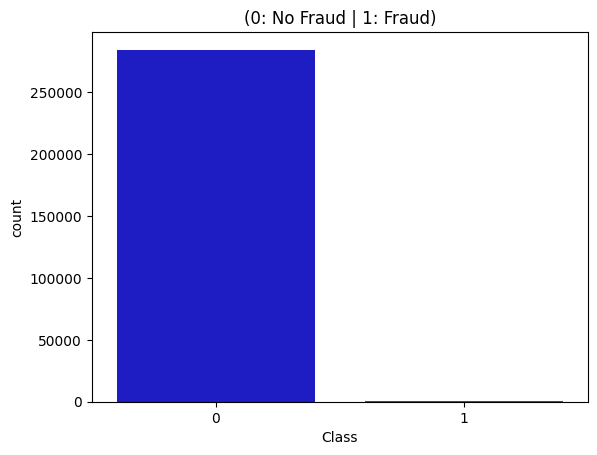

In [141]:
colors = ["#0101DF", "#DF0101"]

# 정상거래와 이상거래 데이터 시각화
sns.countplot(x='Class', data=df, palette=colors)
plt.title('(0: No Fraud | 1: Fraud)')


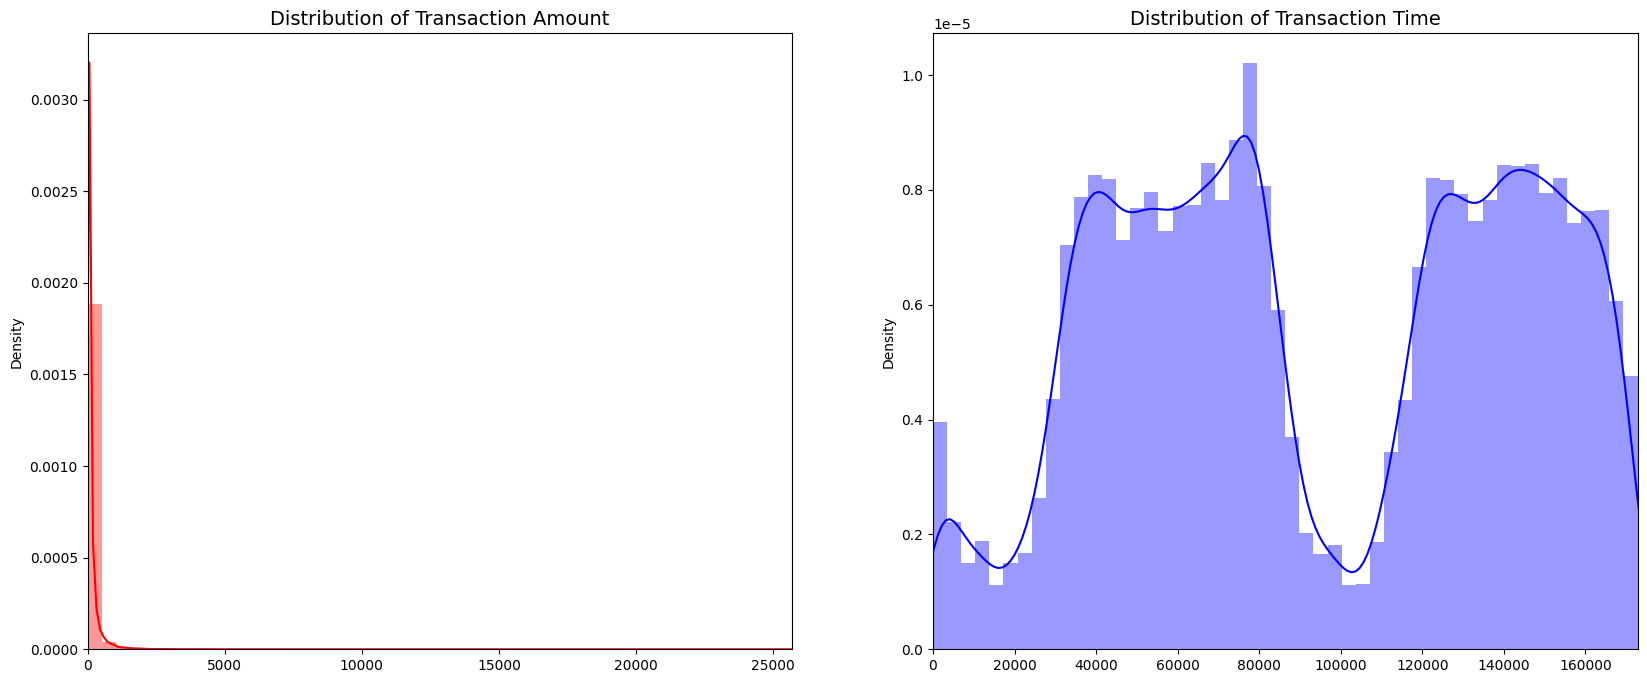

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
amount_val = df['Amount'].values # 'Amount' 열의 값을 추출하여 amount_val 변수에 저장
time_val = df['Time'].values # 'Time' 열의 값을 추출하여 time_val 변수에 저장

# 거래 금액의 시각화
sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

# 거래 시간의 시각화
sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

# 거래 금액이 특정 구간에 집중되어 있다면, 그 구간에 대해 추가 분석을 할 수 있으며,
# 거래 시간이 특정 시간대에 집중되어 있다면 시간대별로 거래 패턴을 분석할 수 있다.

# 이 그래프는 거래 금액과 거래시간에 따른 거래패턴을 파악하기 위해 작성된듯 하다.

### 1. 데이터 분포 확인
* 거래 금액 분포:
그래프에서 확인할 수 있듯이, 거래 금액은 극단적으로 한쪽에 치우쳐 있습니다.
대부분의 거래 금액이 낮은 범위에 집중되어 있으며, 고액 거래는 매우 적습니다.
* 거래 시간 분포:
거래 시간은 더 고르게 분포되어 있으며, 특정 시간대에 피크를 보이는 경향이 있습니다.
이는 하루 중 특정 시간대에 거래가 집중되는 패턴을 나타낼 수 있습니다.


<br>

### 2. 데이터 비율의 불균형
정상 거래와 이상 거래 데이터의 비율은 아래와 같습니다:

정상 거래 데이터셋: 99.83% <br>
이상 거래 데이터셋: 0.17%

이러한 비율의 불균형이 그래프에 영향을 미치는지 분석해 보겠습니다. 정상 거래 데이터가 압도적으로 많기 때문에, 거래 금액과 거래 시간의 분포도 대부분 정상 거래의 패턴을 반영하고 있을 가능성이 큽니다.

<br>

### 영향 분석:
* 거래 금액: 정상 거래가 대부분이므로, 이상 거래는 아주 작은 부분만 차지합니다. 따라서 거래 금액 분포는 대부분 정상 거래의 낮은 금액 패턴을 따르게 됩니다. 이것이 그래프가 한쪽으로 치우쳐 있는 주요 이유입니다.
* 거래 시간: 시간 분포는 정상 거래와 이상 거래 모두에 영향을 받을 수 있지만, 정상 거래가 대부분을 차지하므로 시간 분포도 정상 거래의 패턴을 더 많이 반영할 것입니다.

따라서, 거래 금액 그래프가 극단적으로 치우쳐 있는 주된 이유는 데이터 비율의 불균형 때문입니다. 대부분의 거래가 정상 거래이기 때문에 낮은 금액 거래가 많은 것입니다. 반면, 거래 시간 그래프는 하루 중 특정 시간대에 거래가 집중되는 일반적인 패턴을 나타내며, 정상 거래가 주된 원인으로 보입니다.

<br>

### 결론
정상 거래와 이상 거래 데이터의 불균형이 그래프 분포에 큰 영향을 미친다는 것을 확인할 수 있습니다. 특히 거래 금액의 경우, 대부분의 거래가 낮은 금액의 정상 거래이기 때문에 분포가 한쪽으로 치우쳐 있습니다. 이를 해결하기 위해서는 데이터 균형을 맞추는 기법(예: SMOTE)을 적용해볼 수 있습니다.

## 스케일링 및 분배
이 커널의 이 단계에서는 우선 Time과 Amount 열을 스케일링합니다. Time과 Amount는 다른 열과 동일하게 스케일링해야 합니다. 한편, 이상거래와 정상거래 케이스의 수를 동일하게 맞추어 데이터프레임의 서브 샘플을 생성해야 합니다. 이는 알고리즘이 거래가 이상거래인지 여부를 결정하는 패턴을 더 잘 이해할 수 있도록 도와줍니다.
<br>
### 서브 샘플이란 무엇인가요?
이 시나리오에서 서브 샘플은 이상거래와 정상거래가 50/50 비율로 구성된 데이터프레임을 의미합니다. 즉, 우리의 서브 샘플은 동일한 수의 이상거래와 정상거래를 포함합니다.

### 서브 샘플을 왜 생성하나요?
이 노트북의 초반에 원본 데이터프레임이 심각하게 불균형하다는 것을 확인했습니다! 원본 데이터프레임을 사용하면 다음과 같은 문제가 발생합니다:

* 과적합: 분류 모델이 대부분의 경우에 사기가 없다고 가정하게 됩니다! 우리가 원하는 것은 사기가 발생할 때 모델이 확신할 수 있는 것입니다.
* 잘못된 상관 관계: "V" 특성이 무엇을 의미하는지 모르지만, 불균형한 데이터프레임으로는 클래스와 특성 간의 진정한 상관 관계를 이해할 수 없습니다.

### 요약:

스케일링된 금액과 스케일링된 시간이 스케일링된 값이 있는 열입니다.
데이터셋에는 492건의 사기 사례가 있으므로, 비사기 사례 492건을 무작위로 선택하여 새로운 서브 데이터프레임을 생성할 수 있습니다.
사기 492건과 비사기 492건을 결합하여 새로운 서브 샘플을 만듭니다.

In [143]:
# 데이터 스케일링
from sklearn.preprocessing import StandardScaler, RobustScaler

# Amount의 스케일링:
# 데이터셋에서 다른. 특성들과 비교했을 때 값의 범위가 매우 크고, 모델 학습에 부정적인 영향을 미칠 수 있다.
# 예를 들어, 로지스틱 회귀나 SVM과 같은 모델은 데이터의 스케일에 민감할 수 있다.

std_scaler = StandardScaler() # 데이터의 평균을 0, 표준편차를 1로 맞추는 표준화 작업을 수행한다. 이상치에 민감하다.
rob_scaler = RobustScaler()   # 중위수와 사분위수를 사용하여 스케일링하며, 이상치에 덜 민감하다.

# Amount와 Time을 스케일링 해서 스케일 값을 새로운 컬럼에 저장
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [38]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [144]:
# 스케일된 값을 변수에 따로 저장
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# 스케일된 컬럼을 맨 앞으로 붙인다
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 데이터 분할(Original DataFrame)
랜덤 언더샘플링 기법을 사용하기 전에 원래의 데이터 프레임을 분리해야 합니다. <br> 왜 그럴까요? **랜덤 언더샘플링이나 오버샘플링 기법을 적용할 때 데이터를 분리하더라도, 우리는 이러한 기법들에 의해 생성된 테스트 세트가 아닌 원본 테스트 세트에서 모델을 테스트하고자 합니다.** <br> 주요 목표는 모델을 언더샘플링 및 오버샘플링된 데이터 프레임에 맞추고 원래의 테스트 세트에서 테스트하는 것입니다.

In [145]:
# 신용카드 거래 데이터셋을 불균형 데이터 분할 기법을 사용하여 훈련 세트와 테스트 세트로 나누는 과정

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# 정상거래, 이상거래 데이터 비율과 이상거래 데이터 개수
print('정상거래 데이터셋 중', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '%')
print('이상거래 데이터셋 중', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '%')
print('이상거래 데이터셋 개수', df['Class'].value_counts()[1])

# 타겟 데이터 분리
X = df.drop('Class', axis=1)
y = df['Class']

# StratifiedKFold 객체 생성: 5개의 폴드로 나누고, 클래스 비율을 유지하면서 데이터셋을 분할
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# 훈련을 위한 Train, Test분리
for train_index, test_index in sss.split(X, y):
  print("Train:", train_index, "Test:", test_index)
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# DataFrame에서 array 형태로 변환
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# 라벨 데이터 분포 출력
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)

print('-' * 100)

# 훈련 세트와 테스트 세트의 각 클래스 비율을 출력한다.
print('훈련 세트와 테스트 세트의 각 클래스 비율: \n')
print(train_counts_label/ len(y_train))
print(test_counts_label/ len(y_test))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

정상거래 데이터셋 중 99.83 %
이상거래 데이터셋 중 0.17 %
이상거래 데이터셋 개수 492
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
훈련 세트와 테스트 세트의 각 클래스 비율: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


((227846, 30), (56961, 30), (227846,), (56961,))

## 무작위 언더샘플링:

프로젝트의 이 단계에서는 **'Random Under Sampling'**을 구현할 것입니다. 이는 기본적으로 데이터 세트의 균형을 더 맞추기 위해 데이터를 제거하고 모델을 과적합으로 피하는 것으로 구성됩니다. <br>

### 단계:
* 가장 먼저 해야 할 일은 클래스가 얼마나 불균형한지 확인하는 것입니다(클래스 컬럼의 "value_counts()"를 사용하여 각 레이블의 양을 결정합니다) <br>
* 이상거래로 간주되는 사례가 몇 건인지 결정되면(이상거래 = "1"), 정상거래를 이상거래와 동일한 비율로 만들어야 합니다(50 대 50 비율을 원하는 assuming), 이는 이상거래 492건, 정상거래 492건에 해당합니다. <br>
* 이 기법을 구현한 후에는 클래스와 관련하여 50/50 비율의 데이터 프레임 하위 샘플이 있습니다. 그런 다음 구현할 다음 단계는 이 스크립트를 실행할 때마다 모델이 특정 정확도를 유지할 수 있는지 확인하기 위해 데이터를 섞는 것입니다. <br>

참고: 무작위 언더샘플링의 주요 문제는 많은 정보 손실이 있기 때문에 분류 모델이 원하는 만큼 정확한 성능을 발휘하지 못할 위험이 있다는 것입니다(284,315건의 정상거래 트랜잭션에서 492건의 정상거래
 트랜잭션을 가져옴)


 ---

### 언더샘플링(Undersampling):

* 정의: 다수 클래스의 샘플을 줄여서 클래스 간의 균형을 맞추는 방법입니다.
* 적용: 주로 다수 클래스가 지나치게 많아서 데이터가 불균형할 때 사용합니다. 다수 클래스의 샘플을 랜덤하게 제거하여 데이터셋을 재구성합니다.
* 장점: 샘플 수를 줄이기 때문에 학습 속도가 빨라질 수 있습니다.
* 단점: 유용한 정보를 잃을 수 있으며, 데이터가 적어 과소적합의 위험이 있습니다.

<br>

###오버샘플링(Oversampling):

* 정의: 소수 클래스의 샘플을 복제하거나 합성해서 데이터셋의 균형을 맞추는 방법입니다.
* 적용: 소수 클래스의 샘플이 너무 적어서 분류기가 이를 인식하지 못할 경우 사용합니다. 샘플을 복제하거나 합성하여 데이터셋을 확장합니다.
* 장점: 소수 클래스에 대한 정보를 보다 잘 학습할 수 있으며, 과소적합을 방지할 수 있습니다.
* 단점: 노이즈가 추가될 수 있고, 과적합의 위험이 있을 수 있습니다.

In [146]:
df = df.sample(frac=1) # frac=1은 데이터프레임의 모든 행을 섞어서 반환하라는 의미
fraud_df = df.loc[df['Class'] == 1] # Class == 1 이상거래
non_fraud_df = df.loc[df['Class'] == 0][:492] # Class == 0 정상거래, 이상거래 데이터셋 개수만큼 자른다

# 이상거래 데이터, 정상거래 데이터 병합
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
173901,6.469643,0.434615,1.278375,-3.090176,-0.764980,-1.064159,-1.917791,0.543926,-0.992647,0.045257,...,0.583178,-0.203148,-0.987562,0.059929,0.697347,-0.690926,-0.576872,-0.034400,0.043404,0
263274,-0.296653,0.894959,-0.644278,5.002352,-8.252739,7.756915,-0.216267,-2.751496,-3.358857,1.406268,...,0.816558,0.587728,-0.605759,0.033746,-0.756170,-0.008172,0.532772,0.663970,0.192067,1
258446,-0.044715,0.868948,1.906131,-0.299888,-0.422125,0.405773,-0.503383,0.054657,-0.919197,0.223400,...,-0.048978,0.042684,0.223026,0.306007,0.699702,-0.572718,0.313518,0.004572,-0.009523,0
10630,10.401174,-0.785418,-5.187878,6.967709,-13.510931,8.617895,-11.214422,0.672248,-9.462533,5.328704,...,-0.623737,2.086083,0.760190,0.716806,-0.646743,-1.617043,0.172347,0.626647,-0.169726,1
74794,4.051003,-0.339901,-6.003422,-3.930731,-0.007045,1.714669,3.414667,-2.329583,-1.901512,-2.746111,...,-4.128186,1.101671,-0.992494,-0.698259,0.139898,-0.205151,-0.472412,1.775378,-0.104285,1


## 동등한 분배 및 상관 관계:
이제 데이터 프레임이 올바르게 균형을 이루었으므로 분석 및 데이터 전처리를 더 진행할 수 있습니다.

new_df의 이상거래와 정상거래 클래스 분배
Class
0    0.5
1    0.5
Name: count, dtype: float64


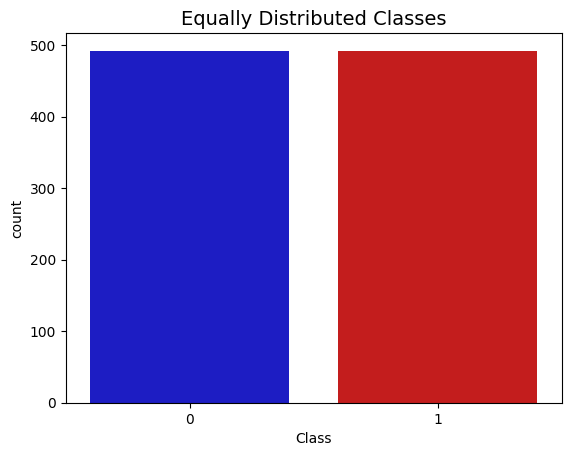

In [147]:
print('new_df의 이상거래와 정상거래 클래스 분배')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## 상관 행렬
상관관계 행렬은 데이터를 이해하는 데 필수적인 요소입니다. 우리는 특정 거래가 사기인지 여부에 큰 영향을 미치는 특징이 있는지 알고 싶습니다. <br> 그러나 사기 거래와 관련하여 어떤 특징이 높은 양의 상관관계를 갖는지 또는 음의 상관관계를 갖는지 확인하기 위해 올바른 데이터 프레임(부표본)을 사용하는 것이 중요합니다.
## 요약 및 설명:
음의 상관관계: V17, V14, V12 및 V10은 음의 상관관계를 갖습니다. 이러한 값이 낮을수록 최종 결과는 사기 거래일 가능성이 높습니다. <br>
양의 상관관계: V2, V4, V11 및 V19는 양의 상관관계가 있습니다. 이러한 값이 높을수록 최종 결과가 사기 거래일 가능성이 높다는 것에 주목하십시오. <br>
BoxPlot: 부정 거래 및 비부정 거래에서 이러한 기능의 분포를 더 잘 이해하기 위해 BoxPlot을 사용합니다. <br>
*참고: * 우리는 상관 행렬에서 하위 샘플을 사용하는지 확인해야 합니다. 그렇지 않으면 우리의 상관 행렬은 우리의 클래스 간의 높은 불균형에 의해 영향을 받습니다. 이것은 원래 데이터 프레임의 높은 클래스 불균형 때문에 발생합니다.

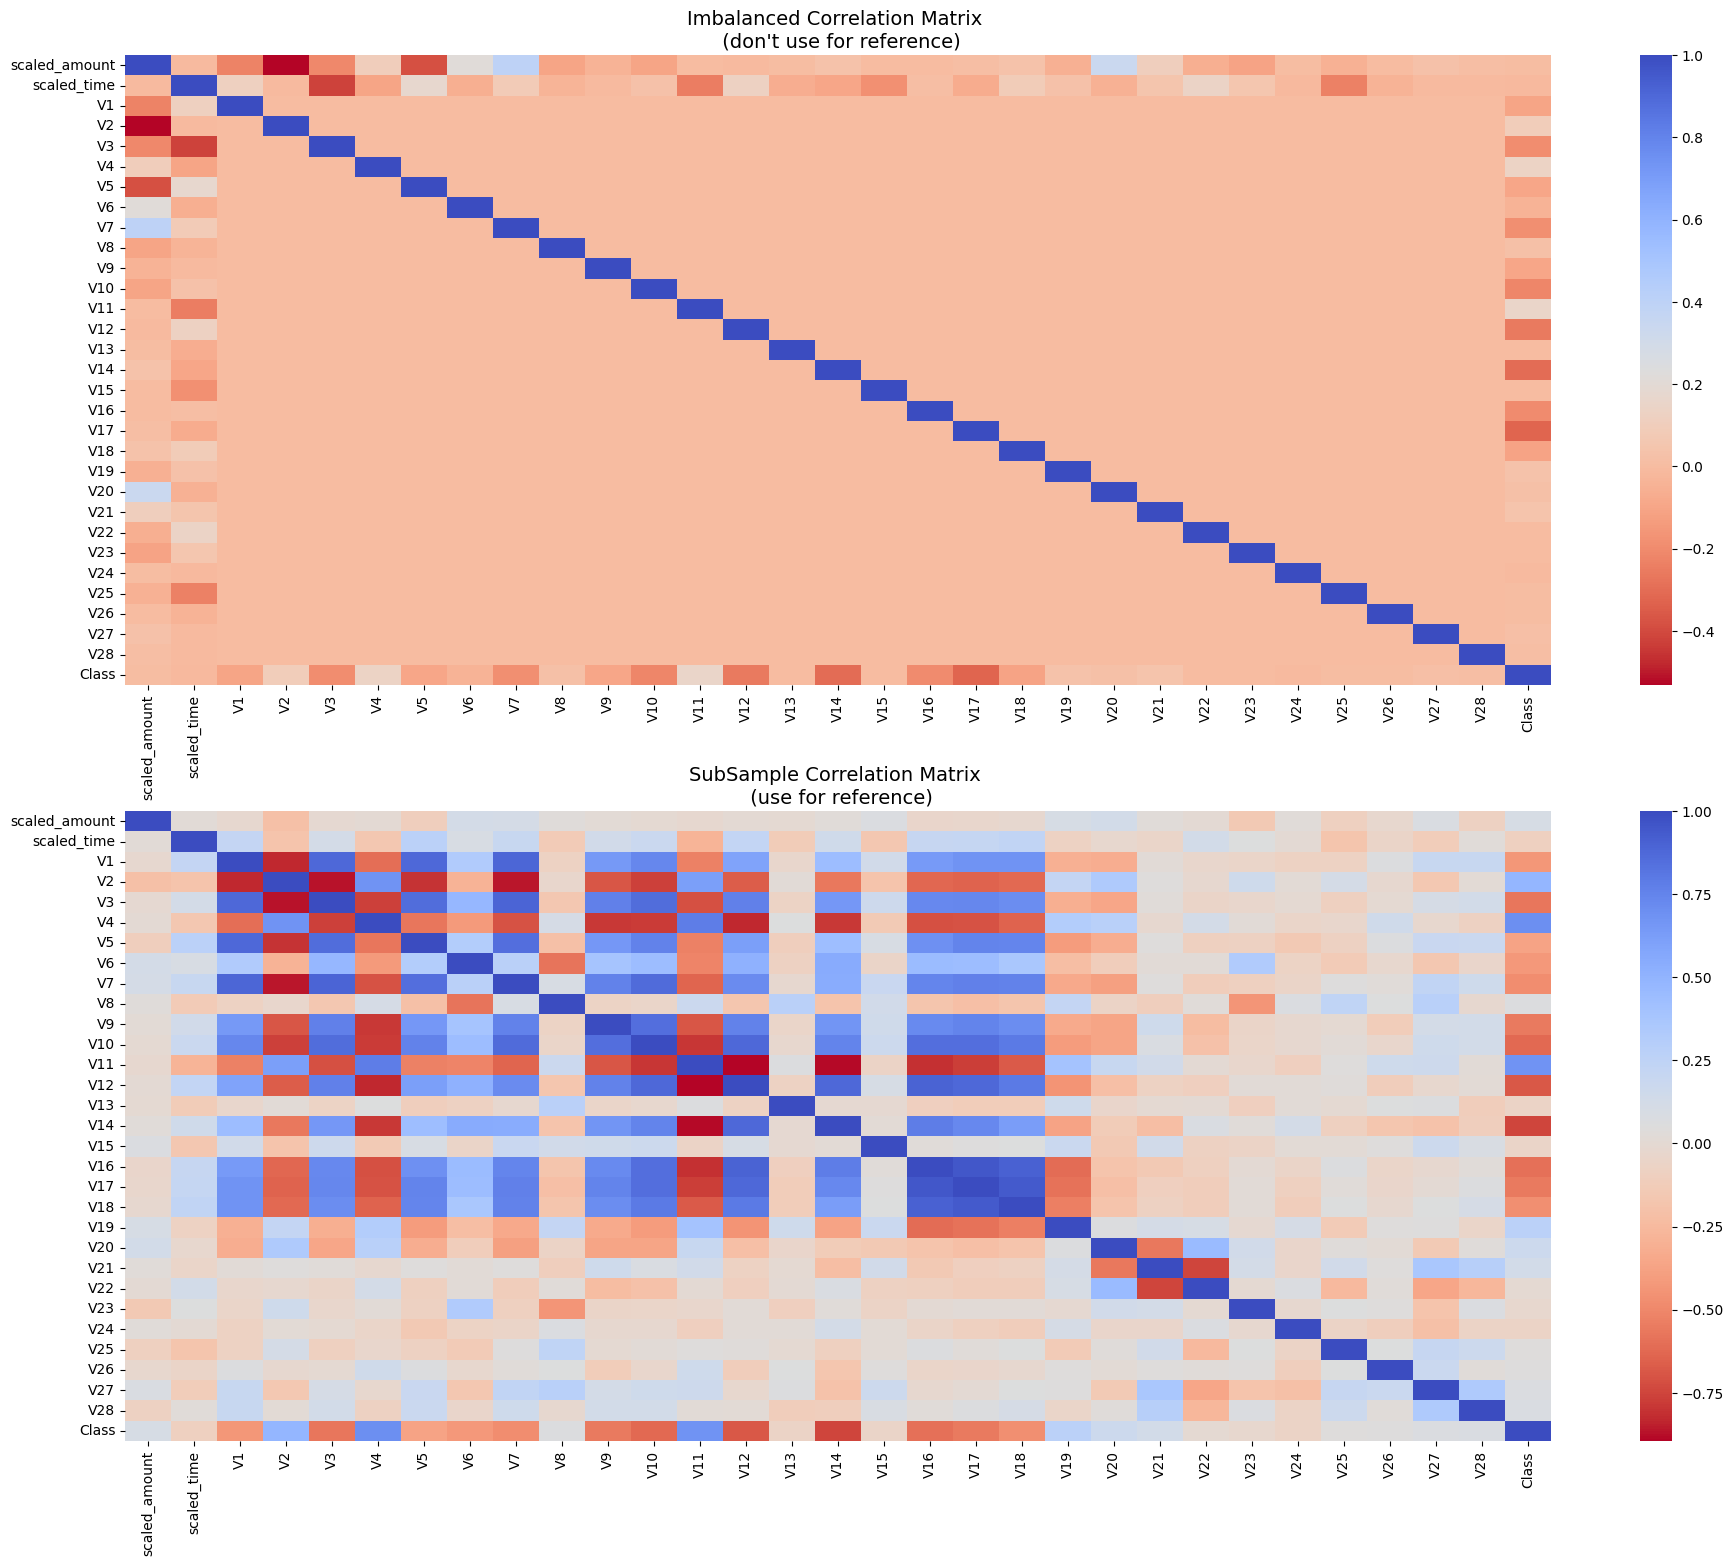

In [148]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(23, 18))
# 상관관계 행렬을 계산

# 이상거래와 정상거래 데이터의 비율이 맞지 않은 원본 데이터프레임
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('Imbalanced Correlation Matrix \n (don\'t use for reference)', fontsize=14)



# 이상거래와 정상거래 데이터의 비율을 동일하게 한 데이터프레임
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

# 두 상관 행렬을 비교하여, 불균형한 데이터셋과 균형 잡힌 샘플을 기반으로 한
# 모델링에서의 변수 상관 관계의 차이점을 시각적으로 보여주고 있다.

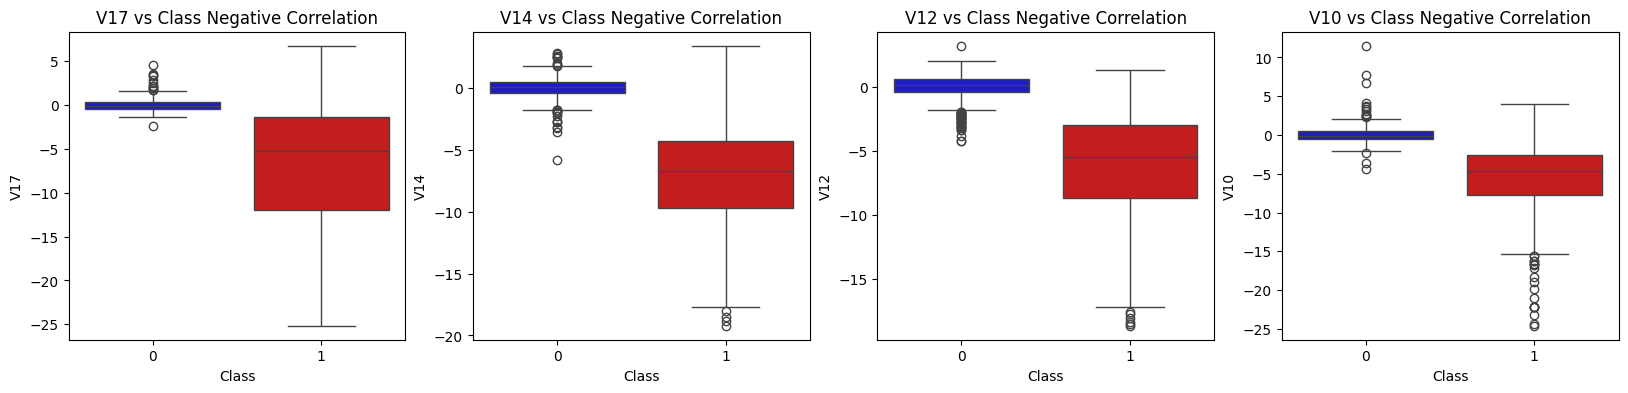

In [149]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# 'Class'와 음의 상관 관계를 가지는 특성들이 있다.
# 이는 특성값이 작을수록 해당 거래가 사기 거래일 가능성이 높다.
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

# 의심이 되는 V17, V14, V12, V10을 박스플롯으로 나타내본다.
plt.show()

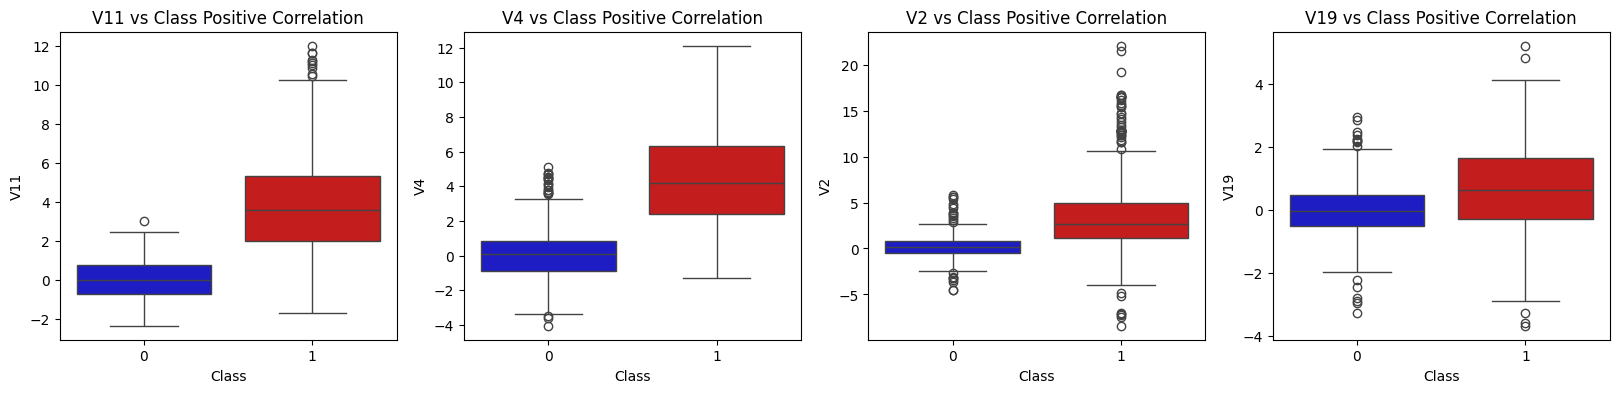

In [150]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# 'Class'와 양의 상관 관계를 가지는 특성들이 있다.
# 이는 특성값이 클수록 해당 거래가 사기 거래일 가능성이 높다.
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

# 의심이 되는 V11, V4, V2, V19를 박스플롯으로 나타내본다.
plt.show()

## Anomaly Detection:

이 섹션에서 우리의 주요 목표는 클래스와 높은 상관 관계를 가지는 특성들에서 "극단적인 이상치(extreme outliers)"를 제거하는 것입니다. <br> 이는 우리 모델의 정확도에 긍정적인 영향을 미칠 것입니다.

<br>

**사분위범위(IQR) 방법:** <br>

* 사분위범위(IQR): 이는 75번째 백분위수와 25번째 백분위수의 차이로 계산됩니다. 우리의 목표는 이를 기준으로 75번째와 25번째 백분위수를 초과하는 경우 해당 인스턴스를 삭제하는 임계값을 생성하는 것입니다.
* 상자 그림(Boxplots): 사분위범위의 끝 부분에 있는 25번째와 75번째 백분위수를 쉽게 볼 수 있을 뿐만 아니라, 극단적인 이상치(하한과 상한을 넘어간 점)도 쉽게 볼 수 있습니다. <br>

**이상치 제거의 트레이드오프:**

* 우리는 이상치를 제거할 임계값을 얼마나 멀리 설정할지에 대해 신중해야 합니다. 우리는 사분위범위에 숫자(예: 1.5)를 곱해 임계값을 결정합니다. 이 임계값이 높을수록(예: 3과 같이 더 높은 숫자를 곱하면) 더 적은 수의 이상치가 검출되고, 임계값이 낮을수록 더 많은 이상치가 검출됩니다.

**트레이드오프:**

* 임계값이 낮을수록 더 많은 이상치가 제거되지만, 우리는 단순히 이상치가 아니라 "극단적인 이상치"에 초점을 맞추려고 합니다. 왜냐하면 이는 모델의 정확도를 낮추는 정보 손실의 위험을 초래할 수 있기 때문입니다. 이 임계값을 조정하면서 분류 모델의 정확도에 어떤 영향을 미치는지 확인할 수 있습니다. <br>

<br>

**요약:**

* 분포 시각화: 우리는 이상치를 제거하는 데 사용할 특성의 분포를 시각화하여 시작합니다. V14 특성은 V12와 V10 특성과 달리 가우시안 분포를 가지고 있습니다.
* 임계값 결정: IQR에 곱할 숫자를 결정한 후, 하한과 상한 임계값을 결정하기 위해 q25에서 임계값을 빼고(q75에 임계값을 더한 후), 이러한 조건이 만족되면 해당 인스턴스를 제거합니다.
* 상자 그림 표현: 상자 그림을 통해 "극단적인 이상치"의 수가 상당히 줄어들었음을 시각적으로 확인할 수 있습니다.

**참고:**
* 이상치 제거를 구현한 후 정확도가 3% 이상 향상되었습니다! 몇 가지 이상치는 모델의 정확도를 왜곡할 수 있지만, 과도한 정보 손실을 피해야 합니다. 그렇지 않으면 모델이 과소적합될 위험이 있습니다.

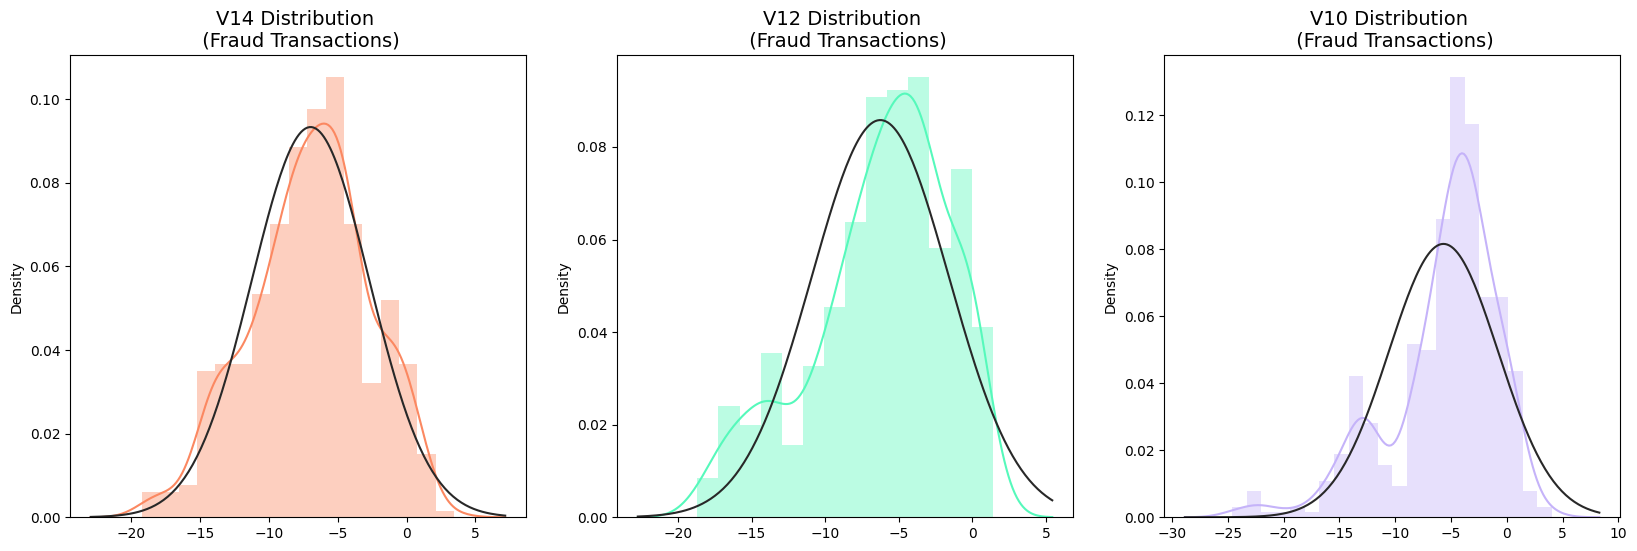

In [151]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# 서브플롯 생성: 1행 3열의 플롯 배열 생성, 크기는 20x6
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# V14 변수의 사기 거래 분포
# 'Class'가 1인 경우(사기 거래)에서 'V14' 값만 추출
v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
# 'V14' 사기 거래 데이터의 분포를 ax1 서브플롯에 그리며, 정규 분포로 피팅
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

# 플롯을 화면에 표시
plt.show()


In [152]:
# -----> V14 이상치 제거 (라벨과 가장 높은 음의 상관관계)
# 'Class'가 1인 경우(사기 거래)에서 'V14' 값만 추출
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values

# 25번째 백분위수와 75번째 백분위수를 계산
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('25번째 백분위수: {} | 75번째 백분위수: {}'.format(q25, q75))

# IQR(Interquartile Range, 사분위수 범위) 계산
v14_iqr = q75 - q25
print('IQR: {}'.format(v14_iqr))

# 이상치 기준값 계산 (IQR의 1.5배)
v14_cut_off = v14_iqr * 1.5
# 이상치 하한선과 상한선 계산
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('기준값: {}'.format(v14_cut_off))
print('V14 하한선: {}'.format(v14_lower))
print('V14 상한선: {}'.format(v14_upper))

# 이상치 추출
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('이상거래의 V14 변수 이상치 수: {}'.format(len(outliers)))
print('V14 이상치: {}'.format(outliers))

# 이상치 제거
new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 변수의 이상치 제거
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 하한선: {}'.format(v12_lower))
print('V12 상한선: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 이상치: {}'.format(outliers))
print('이상거래의 V12 변수 이상치 수: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('이상치 제거 후 인스턴스 수: {}'.format(len(new_df)))
print('----' * 44)

# -----> V10 변수의 이상치 제거
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper



# 1. 사기 거래 데이터에서 변수 값 추출
# 2. 25번째 백분위수(q25)와 75번째 백분위수(q75) 계산
# 3. IQR(사분위수 범위) 계산
# 4. IQR의 1.5배를 기준으로 하한선과 상한선을 설정하여 이상치 범위 결정
# 5. 해당 범위를 벗어나는 값을 이상치로 간주하고 출력
# 6. 이상치를 데이터프레임에서 제거

25번째 백분위수: -9.692722964972386 | 75번째 백분위수: -4.282820849486865
IQR: 5.409902115485521
기준값: 8.114853173228282
V14 하한선: -17.807576138200666
V14 상한선: 3.8320323237414167
이상거래의 V14 변수 이상치 수: 4
V14 이상치: [-19.2143254902614, -18.0499976898594, -18.8220867423816, -18.4937733551053]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 하한선: -17.3430371579634
V12 상한선: 5.776973384895937
V12 이상치: [-18.5536970096458, -18.4311310279993, -18.6837146333443, -18.0475965708216]
이상거래의 V12 변수 이상치 수: 4
이상치 제거 후 인스턴스 수: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


(-14.89885463232024, 4.92033495834214)

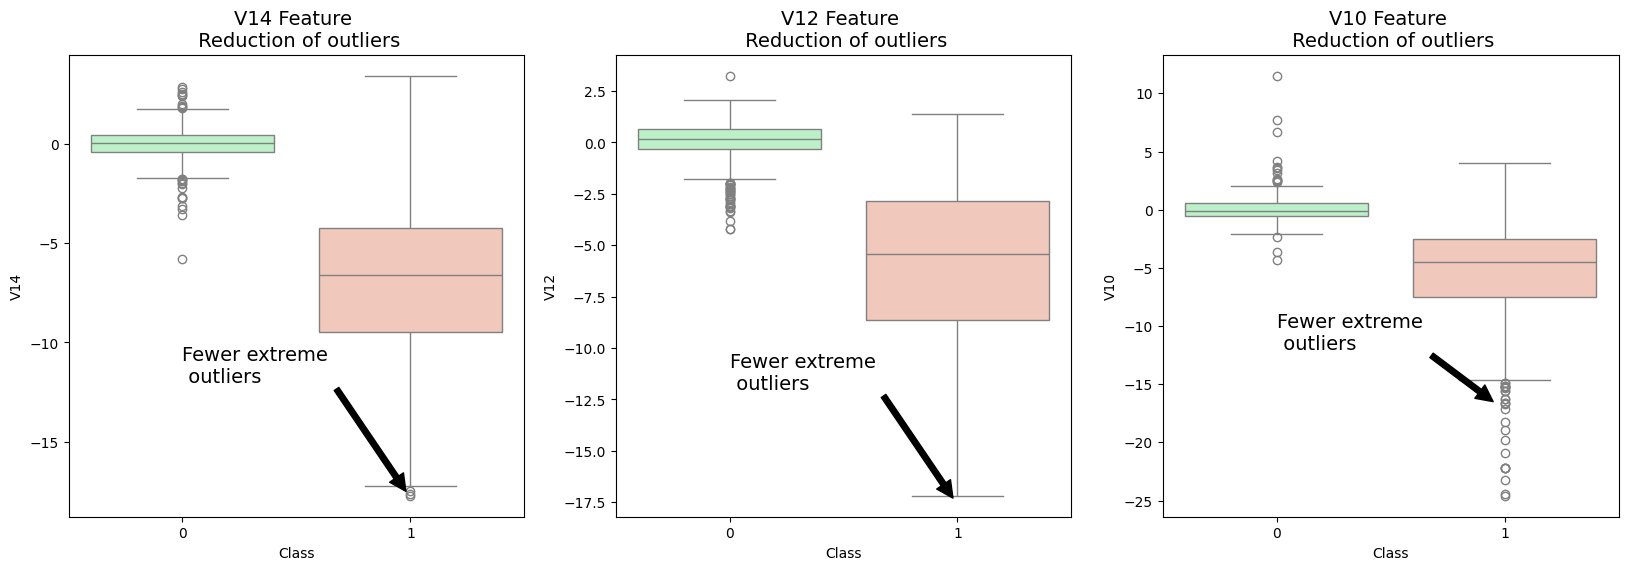

In [153]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# 이상치가 제거된 박스플롯
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

## 차원 축소와 클러스터링:
### t-SNE 이해하기:
이 알고리즘을 이해하기 위해서는 다음 용어들을 이해해야 합니다:

* 유클리드 거리
* 조건부 확률
* 정규 분포와 T-분포 플롯 <br>

**참고:** 간단하게 설명된 t-SNE에 관한 비디오를 보고 싶다면 Joshua Starmer의 StatQuest: t-SNE, Clearly Explained를 참조하세요.

<br>

**요약:**
t-SNE 알고리즘은 데이터셋에서 이상거래와 정상거래 사례들을 상당히 정확하게 클러스터링할 수 있습니다.
비록 하위 샘플이 상당히 작지만, t-SNE 알고리즘은 모든 시나리오에서 거의 정확하게 클러스터를 감지할 수 있습니다 (t-SNE를 실행하기 전에 데이터셋을 섞었습니다). <br>

이는 추가적인 예측 모델이 이상거래와 정상거래를 상당히 잘 구분할 수 있을 것임을 나타냅니다.

<br>

-----------------------------------------------------------------------------

### 차원 축소 : 데이터의 특성을 보존하면서 데이터의 차원 수를 줄이는 방법
1. 데이터 시각화가 용이함(고차원 데이터를 2차원이나 3차원 데이터로 만들어 산점도 등을 그릴수있다)
2. 데이터 처리가 용이하다. 데이터의 복잡성을 줄이고 필요한 특성만 추출한다.

<br>

#### 주성분 분석 PCA (Principal Component Analysis):

PCA는 데이터의 주성분을 찾아 이를 이용하여 데이터를 저차원 공간으로 변환하는 기법
* 기본적으로 데이터의 분산을 최대화하는 주성분을 찾아 차원을 축소한다.
* PCA는 선형 변환을 사용하므로 주로 선형적인 데이터 구조를 잘 표현한다.
* PCA는 주로 데이터 시각화, 데이터 압축, 특징 추출 등에 널리 사용된다.

<br>

#### T-SNE (t-Distributed Stochastic Neighbor Embedding):

T-SNE는 고차원 데이터를 저차원 공간 (주로 2차원 또는 3차원)으로 임베딩하는 비선형 차원 축소 기법이다.
* 데이터 포인트 간의 유사성을 유지하면서 저차원에 임베딩하려는 점에서 PCA와 다르다.
* T-SNE는 주로 데이터의 시각화에 사용되며, 특히 고차원 데이터의 복잡한 구조를 보존하면서 시각적으로 이해하기 쉽게 만드는 데 강점을 가진다..

<br>

#### SVD(Truncated Singular Value Decomposition)
* SVD는 주로 행렬을 특정 요인으로 분해하는 기법으로, TruncatedSVD는 이 기법을 사용하여 차원 축소를 수행한다.
* SVD에서 생성되는 특이값(singular value) 중에서 가장 큰 몇 개만 선택하여 차원을 축소한다는 의미이다.
* TruncatedSVD는 주어진 데이터의 주요 정보를 보존하면서 데이터를 저차원 공간으로 압축하는 데 사용된다.

In [161]:
# New_df는 랜덤 언더샘플링된 데이터에서 나온 것 (적은 인스턴스)
X = new_df.drop('Class', axis=1) # Class 열을 제외한 데이터프레임을 X에 저장
y = new_df['Class'] # Class 열을 y에 저장


# T-SNE 구현
# T-SNE 수행 시간 측정 시작
t0 = time.time()
# X 데이터를 2차원으로 변환, 랜덤 상태 설정
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
# T-SNE 수행 시간 측정 종료
t1 = time.time()
# T-SNE 수행 시간 출력
print("T-SNE took {:.2f} s".format(t1 - t0))

# PCA 구현
# PCA 수행 시간 측정 시작
t0 = time.time()
# X 데이터를 2차원으로 변환, 랜덤 상태 설정
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
# PCA 수행 시간 측정 종료
t1 = time.time()
# PCA 수행 시간 출력
print("PCA took {:.2f} s".format(t1 - t0))

# TruncatedSVD 구현
# Truncated SVD 수행 시간 측정 시작
t0 = time.time()
# X 데이터를 2차원으로 변환, 랜덤 상태 설정, 알고리즘 설정
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
# Truncated SVD 수행 시간 측정 종료
t1 = time.time()
# Truncated SVD 수행 시간 출력
print("Truncated SVD took {:.2f} s".format(t1 - t0))


T-SNE took 9.61 s
PCA took 0.01 s
Truncated SVD took 0.01 s


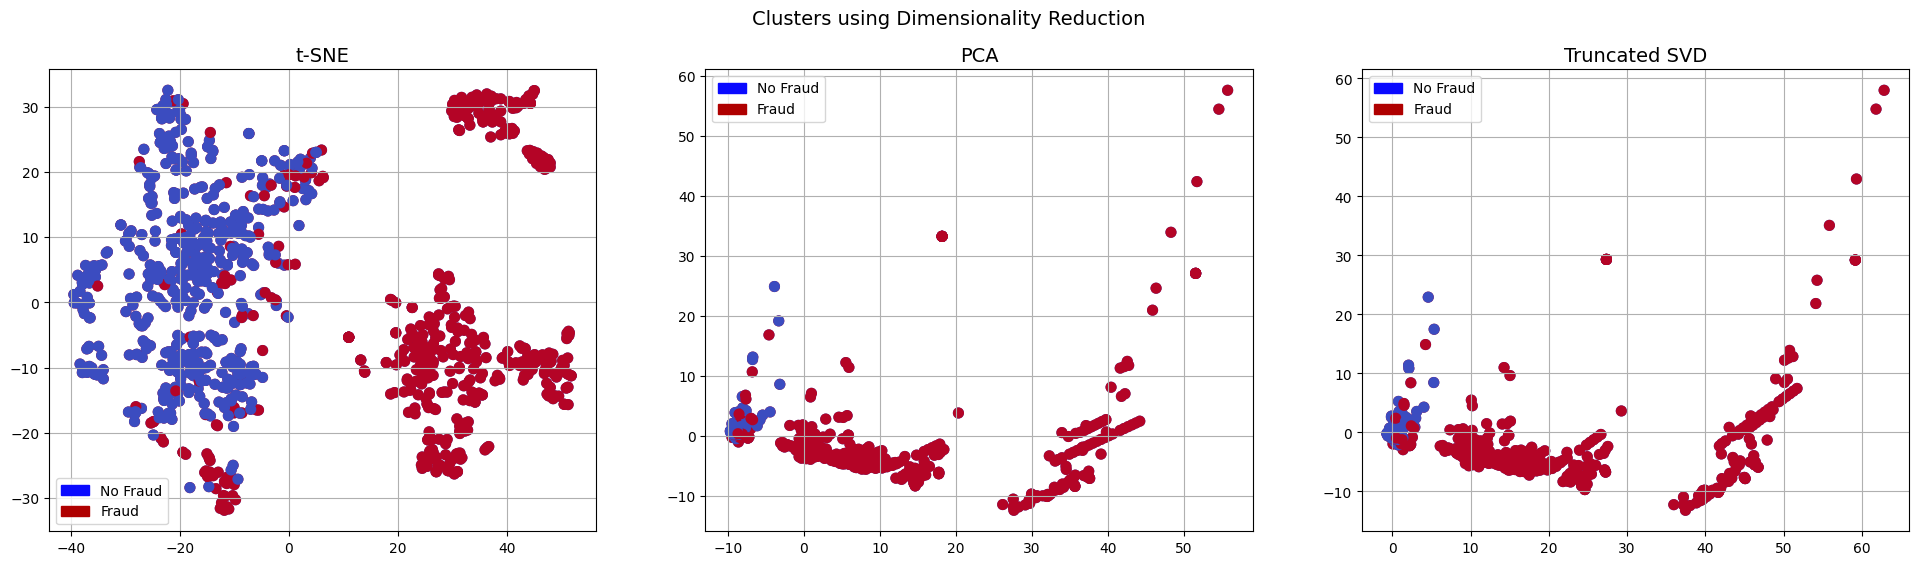

In [162]:
# 서브플롯 생성: 1행 3열의 플롯 배열 생성, 크기는 24x6
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# 제목 : 차원 축소를 이용한 클러스터
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE 산점도
# 'Fraud'와 'No Fraud'를 색상으로 구분하여 산점도를 그림
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA 산점도
# 'Fraud'와 'No Fraud'를 색상으로 구분하여 산점도를 그림
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# Truncated SVD 산점도
# 'Fraud'와 'No Fraud'를 색상으로 구분하여 산점도를 그림
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

# 플롯을 화면에 표시
plt.show()



## Classifiers (UnderSampling):
이 섹션에서는 이상거래를 탐지하는 데 있어서 가장 효과적인 분류기를 결정하기 위해 네 가지 유형의 분류기를 훈련시킵니다. 데이터를 훈련 세트와 테스트 세트로 분리하고 특성과 레이블을 분리하는 작업을 먼저 수행해야 합니다.

<br>

**요약:**

* **로지스틱 회귀 분류기(Logistic Regression Classifier)**는 대부분의 경우 다른 세 가지 분류기보다 정확도가 높습니다. (로지스틱 회귀 분류기에 대해 더 자세히 분석할 예정입니다.) <br>

* **GridSearchCV**는 분류기의 최적의 예측 점수를 제공하는 매개변수를 결정하는 데 사용됩니다.
* **로지스틱 회귀(Logistic Regression)**는 가장 높은 수신자 조작 특성(ROC) 점수를 가지고 있습니다. 이는 로지스틱 회귀가 이상거래 및 정상거래를 상당히 정확하게 분리한다는 의미입니다.
* **학습 곡선(Learning Curves)**: 훈련 점수와 교차 검증 점수 사이의 간격이 넓을수록 모델이 과적합(고분산)될 가능성이 높습니다. 반면에 훈련 점수와 교차 검증 점수가 모두 낮은 경우에는 모델이 과소적합(높은 편향)되었음을 나타냅니다.
* **로지스틱 회귀 분류기(Logistic Regression Classifier)**는 훈련 세트와 교차 검증 세트 모두에서 가장 높은 점수를 보여줍니다.
이러한 결과는 로지스틱 회귀가 이상거래 탐지 모델에서 가장 적합하고 성능이 우수하다는 것을 시사합니다. 따라서 이 모델을 향후 실제 적용에 적합하게 발전시키는 데 중점을 두어야 할 것입니다.

In [163]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [164]:
# 스케일된 데이터를 훈련세트와 테스트세트로 분리
from sklearn.model_selection import train_test_split

# 언더샘플링에 명시적으로 사용된다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [165]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


In [166]:
# 간단한 분류기를 구현

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [167]:
# 매우 높은 점수가 나오는것을 알수있다.
# 하지만 이것은 overfitting 되었다.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 92.0 % accuracy score
Classifiers:  SVC Has a training score of 92.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 89.0 % accuracy score


In [168]:
# GridSearchCV를 사용하여 최적의 파라미터를 찾기 위한 라이브러리 import
from sklearn.model_selection import GridSearchCV

# Logistic Regression 모델의 파라미터 범위 설정
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

#Logistic Regression 모델에 적용하여 최적의 파라미터 찾기
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# 최적의 Logistic Regression 모델 저장
log_reg = grid_log_reg.best_estimator_


# KNN
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_

# SVC
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

# Decision Tree
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_


In [169]:
# Logistic Regression 모델의 교차 검증 점수 계산 및 출력
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

# K-Nearest Neighbors 모델의 교차 검증 점수 계산 및 출력
knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

# Support Vector Classifier 모델의 교차 검증 점수 계산 및 출력
svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

# Decision Tree Classifier 모델의 교차 검증 점수 계산 및 출력
tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  93.72%
Knears Neighbors Cross Validation Score 92.56%
Support Vector Classifier Cross Validation Score 93.97%
DecisionTree Classifier Cross Validation Score 91.54%


### 오버샘플링 및 언더샘플링:
학습 데이터에 대해 오버샘플링(또는 언더샘플링)을 하는 것은 모델이 불균형한 데이터로부터 더 잘 일반화되도록 도울 수 있습니다. 그러나 이는 학습 단계에서만 수행해야 하며, 모델 평가 단계에서는 실제 데이터 분포를 반영해야 합니다.

In [170]:
# 데이터 분포가 불균일한 데이터프레임 사용
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']


sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# 데이터를 훈련 데이터와 테스트 데이터로 스플릿
for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]


undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique
# NearMiss 기법 적용 (레이블 분포 확인을 위한 코드)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# 올바른 방법으로 교차검증
log_reg = LogisticRegression()

# StratifiedShuffleSplit을 사용하여 5-fold 교차 검증 수행
for train_index, test_index in sss.split(undersample_X, undersample_y):
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

    # NearMiss 기법을 사용하여 훈련 데이터에서 다수 클래스(majority) 샘플 언더샘플링
    nearmiss = NearMiss(sampling_strategy='majority')
    X_resampled, y_resampled = nearmiss.fit_resample(undersample_Xtrain, undersample_ytrain)

    # 로지스틱 회귀 모델 훈련
    log_reg.fit(X_resampled, y_resampled)

    # 테스트 데이터에 대해 예측
    y_pred = log_reg.predict(undersample_Xtest)

    # 성능 메트릭 계산
    undersample_accuracy.append(log_reg.score(undersample_Xtest, undersample_ytest))
    undersample_precision.append(precision_score(undersample_ytest, y_pred))
    undersample_recall.append(recall_score(undersample_ytest, y_pred))
    undersample_f1.append(f1_score(undersample_ytest, y_pred))
    undersample_auc.append(roc_auc_score(undersample_ytest, y_pred))

# 성능 메트릭 출력
print("언더샘플링을 적용한 로지스틱 회귀 모델의 성능 메트릭:")
print("평균 정확도 (Accuracy): {:.2f}%".format(np.mean(undersample_accuracy) * 100))
print("평균 정밀도 (Precision): {:.2f}".format(np.mean(undersample_precision)))
print("평균 재현율 (Recall): {:.2f}".format(np.mean(undersample_recall)))
print("평균 F1 점수 (F1 Score): {:.2f}".format(np.mean(undersample_f1)))
print("평균 AUC 점수 (AUC Score): {:.2f}".format(np.mean(undersample_auc)))

# 결과를 보면 낮은 성능 점수를 보여주는것을 알수있다.
# 불균형한 데이터 셋에 언더샘플링 기법을 적용하면 다수의 클래스 데이터가 제거되어 데이터 손실이 크게 발생한다.

Train: [265492 180247  42625 ...  29019  13737  17630] Test: [262992  11354 147255 ... 274515 269798  64110]
Train: [ 72168 114227  16777 ... 264441 191857 284016] Test: [202590  32932 128078 ... 243988 127623  48249]
Train: [ 20846 114568 167610 ... 244465 178911 218462] Test: [284351  82419  90920 ... 171154 168735 271581]
Train: [122204 181602 194344 ... 104571 277576  29389] Test: [225630  63290  67970 ... 279451  77491  75984]
Train: [241649 223426 136900 ...  86431 160465  49565] Test: [157473 204809  83693 ... 251438 178906 216807]
NearMiss Label Distribution: Counter({0: 492, 1: 492})
언더샘플링을 적용한 로지스틱 회귀 모델의 성능 메트릭:
평균 정확도 (Accuracy): 62.31%
평균 정밀도 (Precision): 0.00
평균 재현율 (Recall): 0.93
평균 F1 점수 (F1 Score): 0.01
평균 AUC 점수 (AUC Score): 0.78


In [171]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # 각 분류기에 대한 학습곡선을 그린다.
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    # Second Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")

    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")

    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

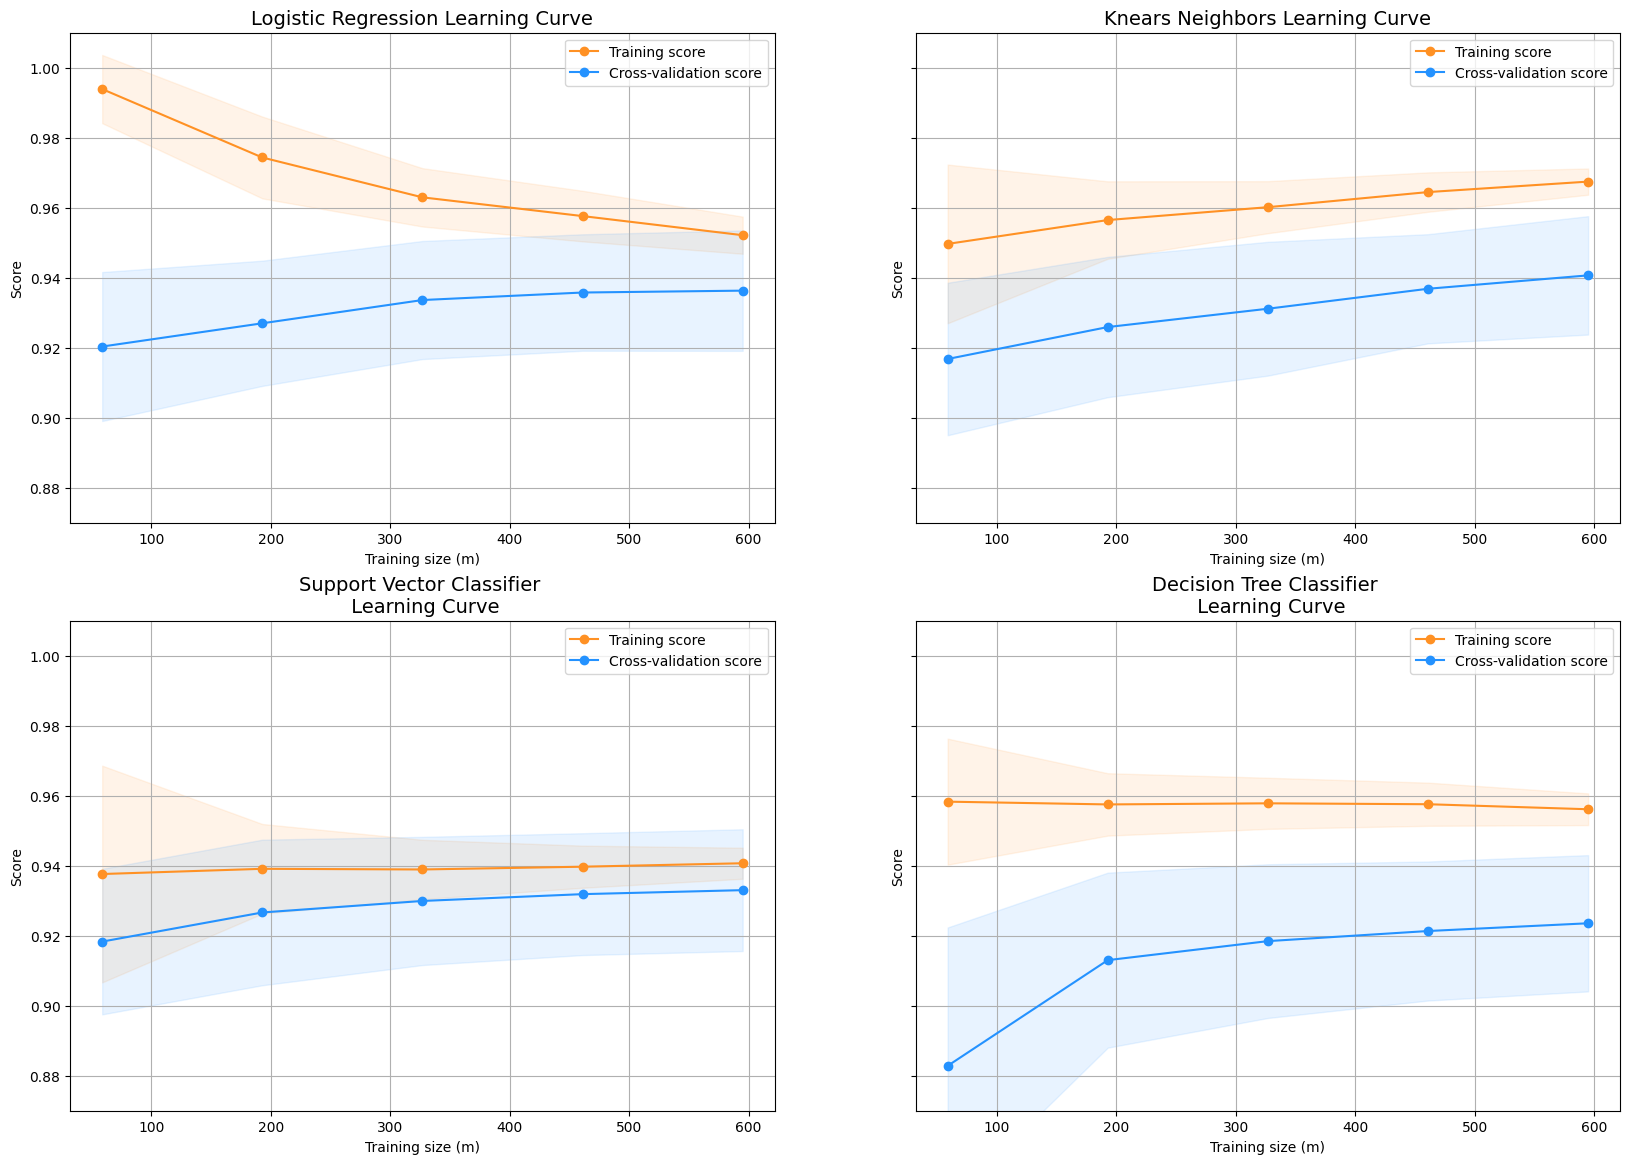

In [71]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [172]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
import pandas as pd

# 각 분류기(Logistic Regression, K-Nearest Neighbors, SVC, Decision Tree)에 대해 5-fold cross-validation 예측을 수행하여 예측 점수를 저장할 DataFrame 생성
scores_df = pd.DataFrame()

# Logistic Regression 예측 점수 계산
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                                 method="decision_function")
scores_df['LogisticRegression'] = log_reg_pred

# K-Nearest Neighbors 예측 점수 계산
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
scores_df['KNearestNeighbors'] = knears_pred

# Support Vector Classifier 예측 점수 계산
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")
scores_df['SupportVectorClassifier'] = svc_pred

# Decision Tree Classifier 예측 점수 계산
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)
scores_df['DecisionTreeClassifier'] = tree_pred

# 예측 점수를 담은 DataFrame 출력
print(scores_df.head())


   LogisticRegression  KNearestNeighbors  SupportVectorClassifier  \
0           -2.059733                  0                -1.687909   
1           -1.717958                  0                -0.863770   
2           -3.822688                  0                -1.985962   
3           18.248385                  1                11.914772   
4           32.937043                  1                20.311746   

   DecisionTreeClassifier  
0                       0  
1                       0  
2                       0  
3                       1  
4                       1  


In [173]:
from sklearn.metrics import roc_auc_score

# 각 분류기 별 roc_auc_score
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9736684659333723
KNears Neighbors:  0.925758880728999
Support Vector Classifier:  0.9756474401541102
Decision Tree Classifier:  0.9154366563882735


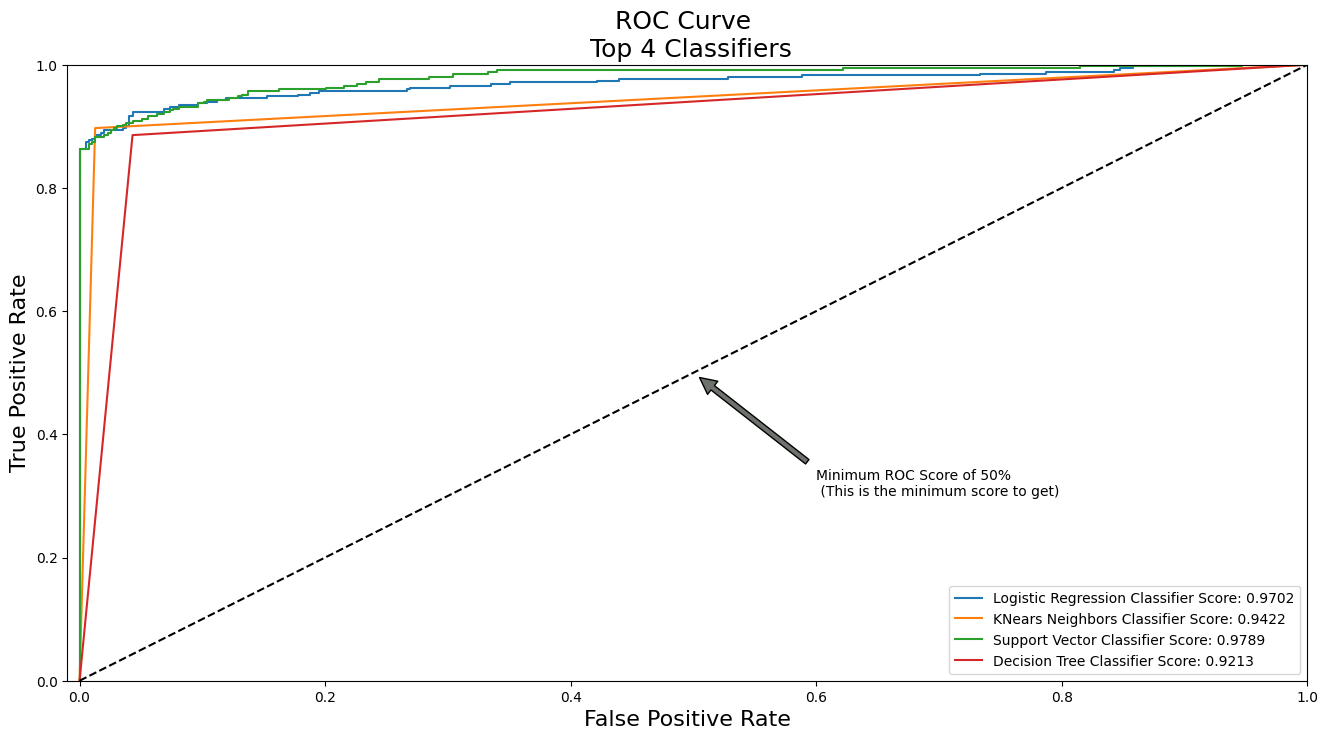

In [74]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)

# 분류기 별 roc_auc커브 그리기
def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## 로지스틱 회귀 분류기에 대한 심층 분석:
이 섹션에서는 로지스틱 회귀 분류기에 대해 깊이 있게 살펴보겠습니다.

### 용어 정의:

* True Positives (TP): 정확하게 분류된 이상거래
* False Positives (FP): 잘못 분류된 이상거래
* True Negatives (TN): 정확하게 분류된 정상거래
* False Negatives (FN): 잘못 분류된 정상거래
* 정밀도(Precision): True Positives / (True Positives + False Positives)
* 재현율(Recall): True Positives / (True Positives + False Negatives)

* 정밀도는 모델이 사기 거래를 얼마나 정확하게 탐지하는지를 나타내며, 재현율은 모델이 얼마나 많은 사기 사례를 탐지할 수 있는지를 나타냅니다.

* **정밀도/재현율의 상충 관계(Tradeoff)**: 모델이 더 정밀할수록(더 선택적일수록) 탐지할 사례가 줄어듭니다. 예를 들어, 모델의 정밀도가 95%라고 가정해봅시다. 모델이 95% 이상의 확률로 사기 거래라고 확신하는 경우가 5건 있다고 가정합니다. 이때, 모델이 90% 확률로 사기 거래라고 생각하는 경우가 5건 더 있다고 가정하면, 정밀도를 낮추면 모델이 탐지할 수 있는 사례가 더 많아집니다.

### 요약:
정밀도는 0.90에서 0.92 사이에서 감소하기 시작하지만, 우리의 정밀도 점수는 여전히 상당히 높으며 재현율 점수도 여전히 괜찮습니다.

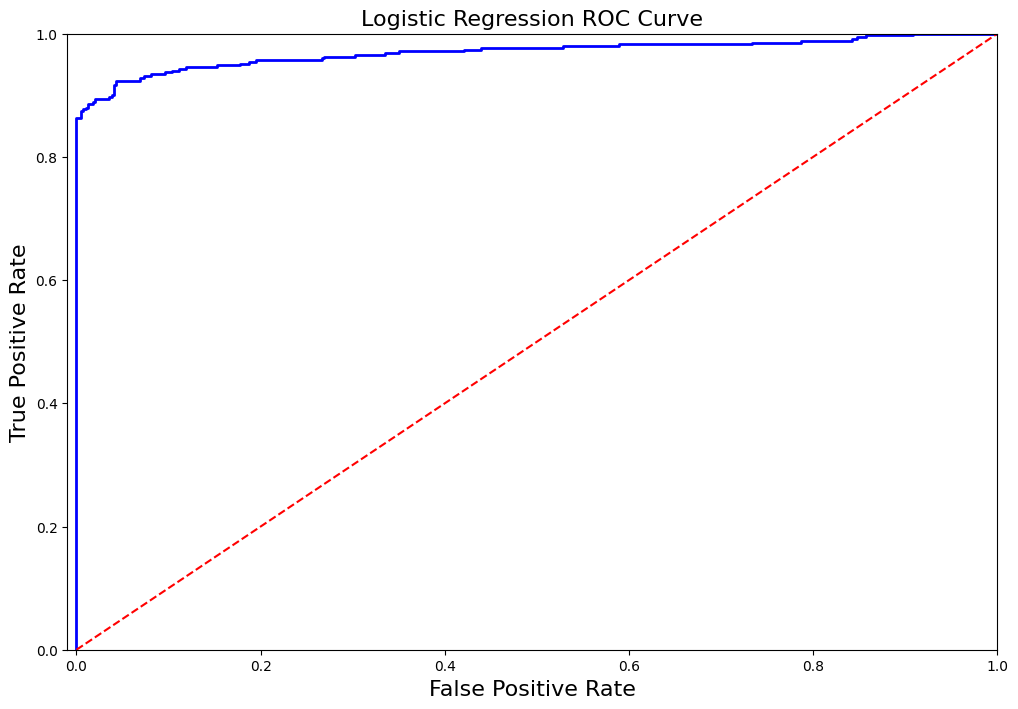

In [75]:
# 로지스틱 회귀의 roc 커브
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])


logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [174]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [175]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case 평가 결과 출력
print('---' * 45)
print('Overfitting: \n')
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('---' * 45)

# 모델이 일반화되었을 때, 즉 과적합되지 않았을 때 기대할 수 있는 성능
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Accuracy Score: 0.77
Precision Score: 0.71
Recall Score: 0.94
F1 Score: 0.81
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.62
Precision Score: 0.00
Recall Score: 0.93
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------


In [176]:
undersample_y_score = log_reg.decision_function(X_test)

In [177]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(y_test, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.90


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.90')

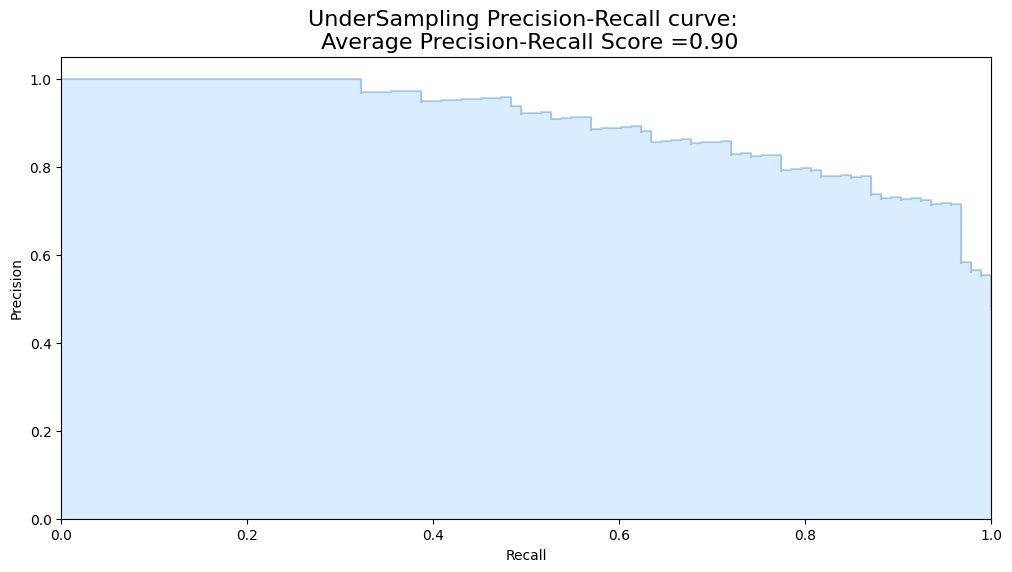

In [178]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_test, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

## SMOTE 기법 (Over-Sampling)


### SMOTE란?
**SMOTE**는 Synthetic Minority Over-sampling Technique(합성 소수 과샘플링 기법)의 약자입니다. 랜덤 언더샘플링과 달리, SMOTE는 새로운 합성 포인트를 만들어 클래스의 균형을 맞추는 방법입니다. 이는 클래스 불균형 문제를 해결하기 위한 또 다른 대안입니다.

<br>

### SMOTE 이해하기:
* 클래스 불균형 해결: SMOTE는 소수 클래스에서 합성 포인트를 만들어 다수 클래스와의 균형을 맞춥니다.
* 합성 포인트의 위치: SMOTE는 소수 클래스의 가장 가까운 이웃 간의 거리를 선택하고, 이 거리 사이에 합성 포인트를 생성합니다.
* 최종 효과: 랜덤 언더샘플링과 달리 행을 삭제할 필요가 없기 때문에 더 많은 정보를 유지할 수 있습니다.
* 정확도와 시간의 트레이드오프: SMOTE는 랜덤 언더샘플링보다 더 정확할 가능성이 있지만, 행을 제거하지 않기 때문에 훈련에 더 많은 시간이 걸립니다.

## 교차 검증에서 과적합 문제:

### 교차 검증에서 과적합:
언더샘플링 분석에서 제가 겪은 흔한 실수를 공유하고자 합니다. 간단히 말해, 데이터를 언더샘플링하거나 오버샘플링하려면 교차 검증 전에 하면 안 됩니다. 왜냐하면 교차 검증을 시행하기 전에 검증 세트에 직접적인 영향을 미치게 되어 "데이터 누출" 문제가 발생하기 때문입니다. **다음 섹션에서는 놀라운 정밀도와 재현율 점수를 보게 되겠지만, 실제로는 데이터가 과적합되고 있습니다!**


### 잘못된 방법:
<img src=https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401> <br>
앞서 언급했듯이, 소수 클래스(우리의 경우 "이상거래")를 가져와 합성 포인트를 교차 검증 전에 생성하면 교차 검증 과정의 "검증 세트"에 특정한 영향을 미치게 됩니다. 교차 검증이 어떻게 작동하는지 기억해봅시다. 데이터를 5개 배치로 나누고 4/5는 훈련 세트, 1/5는 검증 세트가 됩니다. 테스트 세트는 건드리지 않아야 합니다! 이 때문에, 합성 데이터 포인트 생성은 교차 검증 "도중"에 해야 하며, 교차 검증 전에 하면 안 됩니다.

<br>

### 올바른 방법:
<img src=https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372> <br>
위에서 보듯이, SMOTE는 교차 검증 도중에 발생하고 교차 검증 과정 이전에 발생하지 않습니다. 합성 데이터는 훈련 세트에만 생성되며 검증 세트에는 영향을 미치지 않습니다.

<br>

참고 자료:
* DEALING WITH IMBALANCED DATA: UNDERSAMPLING, OVERSAMPLING AND PROPER CROSS-VALIDATION
* SMOTE explained for noobs
* Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn


In [181]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(X_train, y_train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(X_train[train], y_train[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(X_train[test])

    accuracy_lst.append(pipeline.score(X_train[test], y_train[test]))
    precision_lst.append(precision_score(y_train[test], prediction))
    recall_lst.append(recall_score(y_train[test], prediction))
    f1_lst.append(f1_score(y_train[test], prediction))
    auc_lst.append(roc_auc_score(y_train[test], prediction))

print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 780 | Length of y (train): 780
Length of X (test): 196 | Length of y (test): 196
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9269230769230768
precision: 0.9670711462450592
recall: 0.8846153846153847
f1: 0.9234457783113246
---------------------------------------------------------------------------------------------------------------------------------------


In [86]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(X_test)
print(classification_report(y_test, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       0.80      1.00      0.89        96
       Fraud       1.00      0.73      0.85        90

    accuracy                           0.87       186
   macro avg       0.90      0.87      0.87       186
weighted avg       0.90      0.87      0.87       186



In [87]:
y_score = best_est.decision_function(X_test)

In [88]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.98


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.98')

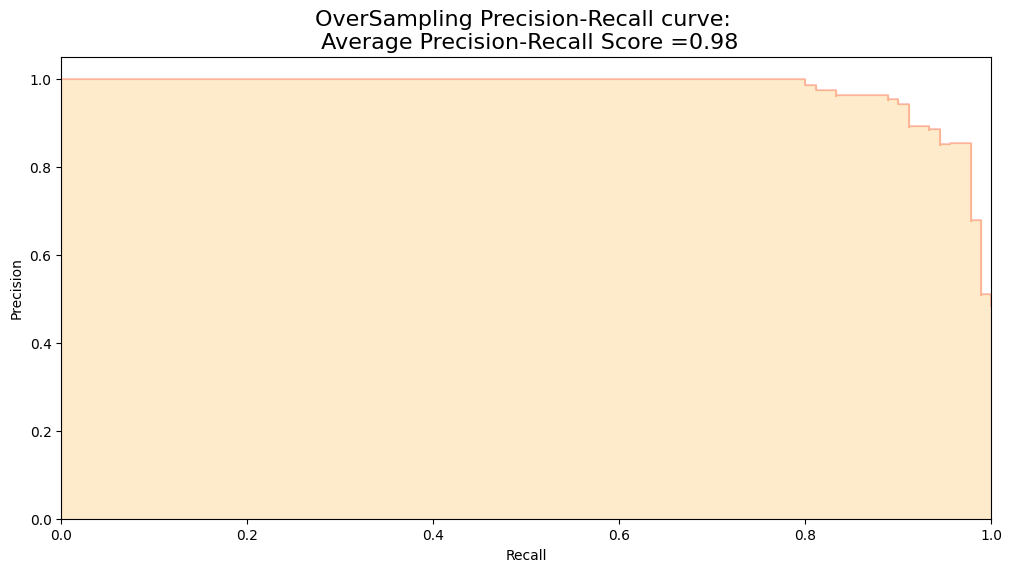

In [89]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [92]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='auto', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

In [93]:
# We Improve the score by 2% points approximately
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :0.03437685966491699 sec


## 로지스틱 회귀를 사용한 테스트 데이터:

### 혼동 행렬 (Confusion Matrix):
**Positive/Negative**: 클래스(레이블)의 유형 ["No", "Yes"]

**True/False**: 모델이 정확하게 또는 부정확하게 분류한 여부

**True Negatives (좌상단 사각형)**: "No" (이상거래 탐지 안됨) 클래스를 정확하게 분류한 수

**False Negatives (우상단 사각형)**: "No" (이상거래 탐지 안됨) 클래스를 부정확하게 분류한 수

**False Positives (좌하단 사각형)**: "Yes" (이상거래 탐지됨) 클래스를 부정확하게 분류한 수

**True Positives (우하단 사각형)**: "Yes" (이상거래 탐지됨) 클래스를 정확하게 분류한 수

### 요약:
* **랜덤 언더샘플링**: 우리는 랜덤 언더샘플링된 데이터셋에서 분류 모델의 최종 성능을 평가할 것입니다. 이는 원본 데이터프레임의 데이터가 아님을 유의하십시오.
* **분류 모델**: 가장 성능이 좋았던 모델은 로지스틱 회귀와 서포트 벡터 분류기(SVM)였습니다.

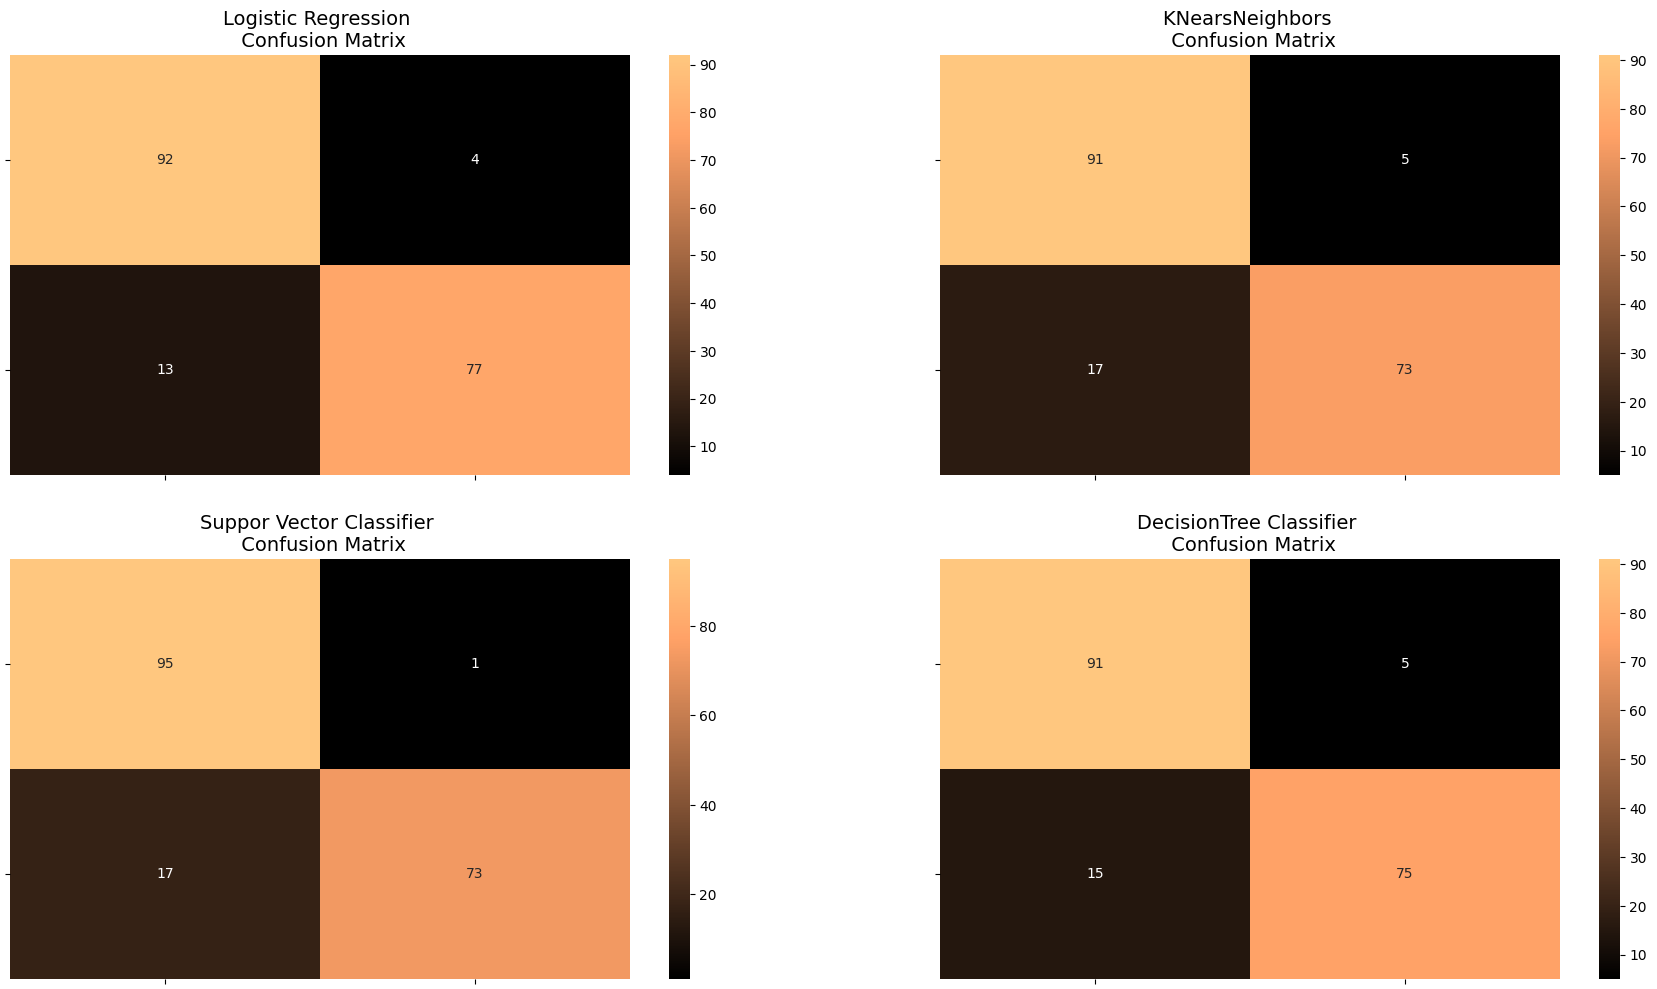

In [94]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [95]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        96
           1       0.95      0.86      0.90        90

    accuracy                           0.91       186
   macro avg       0.91      0.91      0.91       186
weighted avg       0.91      0.91      0.91       186

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        96
           1       0.94      0.81      0.87        90

    accuracy                           0.88       186
   macro avg       0.89      0.88      0.88       186
weighted avg       0.89      0.88      0.88       186

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91        96
           1       0.99      0.81      0.89        90

    accuracy                           0.90       186
   macro avg       0.92      0.90      0.90       186
weighted

In [96]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(X_test)
oversample_score = accuracy_score(y_test, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading!
final_df

,Technique,Score
0,Random UnderSampling,0.784946
1,Oversampling (SMOTE),0.870968


# 신경망 테스트: 랜덤 언더샘플링 데이터 대 오버샘플링(SMOTE)

이 섹션에서는 단순한 신경망(하나의 은닉층이 있는)을 구현하여 (언더샘플링 또는 오버샘플링(SMOTE))에서 어떤 로지스틱 회귀 모델이 이상거래와 정상거래를 감지하는 데 더 나은 정확도를 가지는지 확인해 보겠습니다.

<br>

### 주요 목표:
우리의 주요 목표는 단순 신경망이 랜덤 언더샘플링과 오버샘플링된 데이터프레임에서 어떻게 작동하는지 탐구하고, 이들이 정상거래 및 이상거래 사례를 정확하게 예측할 수 있는지 확인하는 것입니다. 왜 이상거래만 집중하지 않을까요? 당신이 카드 소유자라고 가정하고 물건을 구매한 후에 은행의 알고리즘이 당신의 구매를 이상거래로 인식해서 카드가 차단되었다고 상상해보세요. 그렇기 때문에 이상거래 사례를 탐지하는 것에만 집중할 것이 아니라 정상거래를 올바르게 분류하는 것에도 집중해야 합니다.

<br>

### 혼동 행렬:
다시 말하지만, 혼동 행렬은 다음과 같이 작동합니다:

* **좌상단 사각형**: 정상거래를 모델이 정확하게 분류한 수
* **우상단 사각형**: 이상거래 사례로 잘못 분류된 정상거래의 수
* **좌하단 사각형**: 정상거래 사례로 잘못 분류된 이상거래의 수
* **우하단 사각형**: 이상거래를 모델이 정확하게 분류한 수

<br>

### 요약 (Keras || 랜덤 언더샘플링):
* **데이터셋**: 최종 테스트 단계에서는 이 모델을 랜덤 언더샘플링된 하위 집합과 오버샘플링된 데이터셋(SMOTE)에 맞춰 원본 데이터프레임 테스트 데이터를 사용하여 최종 결과를 예측합니다.
* **신경망 구조**: 앞서 언급했듯이, 이 모델은 하나의 입력층(노드 수는 특징 수와 동일)과 바이어스 노드, 32개의 노드가 있는 하나의 은닉층, 0 또는 1(정상거래 또는 이상거래)의 두 가지 가능한 결과를 가지는 하나의 출력 노드로 구성된 단순한 모델입니다.
* **기타 특성**: 학습률은 0.001, 사용되는 옵티마이저는 AdamOptimizer, 이 시나리오에서 사용되는 활성화 함수는 "Relu"이며, 최종 출력에 대해서는 희소 범주형 교차 엔트로피를 사용합니다. 이는 인스턴스 사례가 비사기인지 사기인지의 확률을 제공하며(예측은 두 가지 중 높은 확률을 선택합니다).


In [98]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from tensorflow.keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [99]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1988 (7.77 KB)
Trainable params: 1988 (7.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [101]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
24/24 - 2s - loss: 0.8387 - accuracy: 0.5681 - val_loss: 0.4037 - val_accuracy: 0.7517 - 2s/epoch - 83ms/step
Epoch 2/20
24/24 - 0s - loss: 0.3924 - accuracy: 0.8151 - val_loss: 0.3056 - val_accuracy: 0.9060 - 122ms/epoch - 5ms/step
Epoch 3/20
24/24 - 0s - loss: 0.3045 - accuracy: 0.9092 - val_loss: 0.2696 - val_accuracy: 0.9396 - 128ms/epoch - 5ms/step
Epoch 4/20
24/24 - 0s - loss: 0.2531 - accuracy: 0.9227 - val_loss: 0.2371 - val_accuracy: 0.9396 - 120ms/epoch - 5ms/step
Epoch 5/20
24/24 - 0s - loss: 0.2139 - accuracy: 0.9361 - val_loss: 0.2197 - val_accuracy: 0.9396 - 126ms/epoch - 5ms/step
Epoch 6/20
24/24 - 0s - loss: 0.1865 - accuracy: 0.9395 - val_loss: 0.2070 - val_accuracy: 0.9396 - 121ms/epoch - 5ms/step
Epoch 7/20
24/24 - 0s - loss: 0.1651 - accuracy: 0.9479 - val_loss: 0.1993 - val_accuracy: 0.9396 - 122ms/epoch - 5ms/step
Epoch 8/20
24/24 - 0s - loss: 0.1485 - accuracy: 0.9479 - val_loss: 0.1974 - val_accuracy: 0.9396 - 128ms/epoch - 5ms/step
Epoch 9/20
24/24 -

In [102]:
undersample_predictions = undersample_model.predict(X_test, batch_size=200, verbose=0)

In [125]:
# 예측 확률 생성
probabilities = undersample_model.predict(X_test, batch_size=200, verbose=0)
# 확률을 클래스 (0 또는 1)로 변환
undersample_fraud_predictions = (probabilities > 0.5).astype("int32")
# undersample_fraud_probabilities = undersample_model.predict(X_test, batch_size=200, verbose=0)
# undersample_fraud_predictions = (undersample_fraud_probabilities > 0.5).astype(int)

In [118]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[15 76]
 [28 81]]
Confusion matrix, without normalization
[[ 91   0]
 [  0 109]]


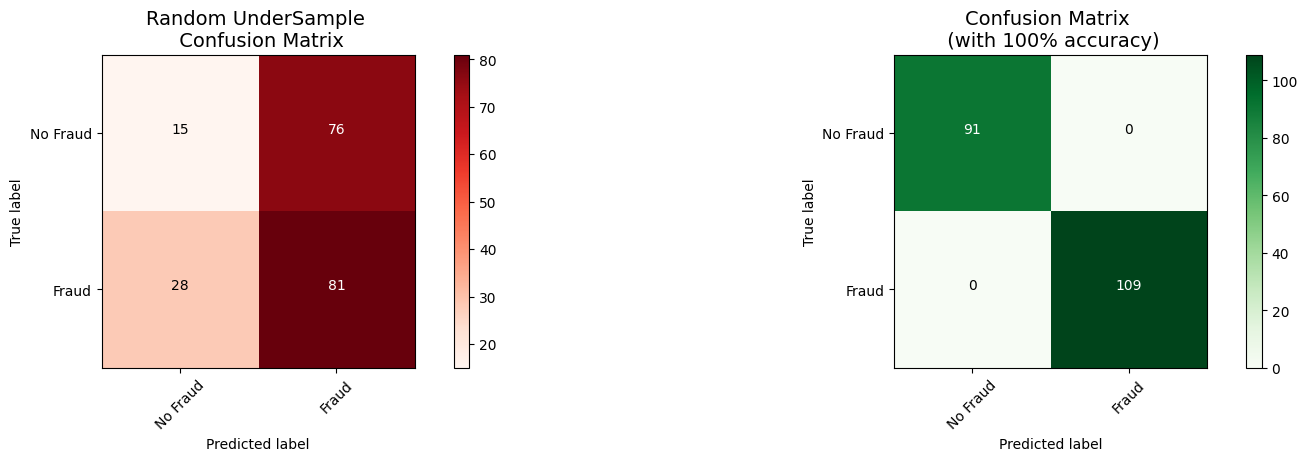

In [126]:
undersample_cm = confusion_matrix(y_test, undersample_fraud_predictions)
actual_cm = confusion_matrix(y_test, y_test)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

## Keras || OverSampling (SMOTE):

In [127]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [128]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [129]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
3/3 - 1s - loss: 1.0868 - accuracy: 0.4270 - val_loss: 1.0297 - val_accuracy: 0.4557 - 817ms/epoch - 272ms/step
Epoch 2/20
3/3 - 0s - loss: 0.8454 - accuracy: 0.5302 - val_loss: 0.7357 - val_accuracy: 0.6203 - 32ms/epoch - 11ms/step
Epoch 3/20
3/3 - 0s - loss: 0.6833 - accuracy: 0.6159 - val_loss: 0.5668 - val_accuracy: 0.6835 - 34ms/epoch - 11ms/step
Epoch 4/20
3/3 - 0s - loss: 0.5928 - accuracy: 0.6524 - val_loss: 0.4883 - val_accuracy: 0.7215 - 33ms/epoch - 11ms/step
Epoch 5/20
3/3 - 0s - loss: 0.5427 - accuracy: 0.6746 - val_loss: 0.4447 - val_accuracy: 0.7342 - 31ms/epoch - 10ms/step
Epoch 6/20
3/3 - 0s - loss: 0.5106 - accuracy: 0.7143 - val_loss: 0.4112 - val_accuracy: 0.7595 - 36ms/epoch - 12ms/step
Epoch 7/20
3/3 - 0s - loss: 0.4821 - accuracy: 0.7429 - val_loss: 0.3849 - val_accuracy: 0.7785 - 35ms/epoch - 12ms/step
Epoch 8/20
3/3 - 0s - loss: 0.4538 - accuracy: 0.7683 - val_loss: 0.3639 - val_accuracy: 0.8038 - 45ms/epoch - 15ms/step
Epoch 9/20
3/3 - 0s - loss: 0.

In [133]:
# X_test의 현재 형상을 확인
print(X_test.shape)

import numpy as np
X_test = np.random.rand(200, 30)
print(X_test.shape)

# 모델 예측
probabilities = oversample_model.predict(X_test, batch_size=200, verbose=0)
oversample_predictions = (probabilities > 0.5).astype("int32")


(200, 2)
(200, 30)


In [135]:
# 예측 확률 생성
probabilities = oversample_model.predict(X_test, batch_size=200, verbose=0)

# 확률을 클래스 (0 또는 1)로 변환
oversample_fraud_predictions = (probabilities > 0.5).astype("int32")


(200,)
(200, 2)


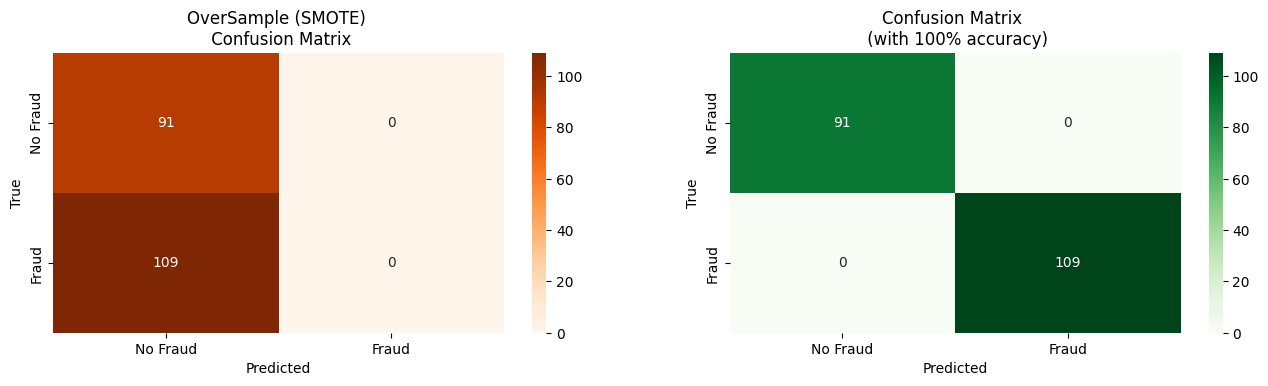

In [137]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# y_test가 1차원 배열인지 확인
print(y_test.shape)
# oversample_fraud_predictions가 1차원 배열인지 확인
print(oversample_fraud_predictions.shape)

# oversample_fraud_predictions를 1차원 배열로 변환 (필요한 경우)
if oversample_fraud_predictions.ndim > 1 and oversample_fraud_predictions.shape[1] > 1:
    oversample_fraud_predictions = np.argmax(oversample_fraud_predictions, axis=1)

# confusion_matrix 계산
oversample_smote = confusion_matrix(y_test, oversample_fraud_predictions)
actual_cm = confusion_matrix(y_test, y_test)
labels = ['No Fraud', 'Fraud']

# confusion_matrix 시각화 함수
def plot_confusion_matrix(cm, labels, title='Confusion Matrix', cmap=plt.cm.Blues):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')

# 시각화
fig = plt.figure(figsize=(16, 8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

plt.show()


### 결론:
우리의 불균형 데이터셋에 SMOTE를 적용한 것은 레이블의 불균형(정상거래가 이상거래보다 많은)을 해결하는 데 도움이 되었습니다. 그럼에도 불구하고, 때로는 오버샘플링된 데이터셋에서 신경망이 언더샘플링된 데이터셋을 사용하는 모델보다 이상거래를 정확하게 예측하지 못한다는 점을 지적해야 합니다.

그러나 이 점을 기억하세요. 이상값 제거는 오직 랜덤 언더샘플링된 데이터셋에만 적용되었으며, 오버샘플링된 데이터셋에는 적용되지 않았습니다. 또한, 언더샘플링된 데이터에서는 모델이 많은 정상거래를 올바르게 탐지하지 못하고 대신 정상거래를 이상거래로 잘못 분류하는 경우가 많습니다.

예를 들어, 일반 구매를 한 사람들이 모델이 해당 거래를 이상거래로 분류한 이유로 인해 카드가 차단되었다고 상상해 보십시오. 이는 금융 기관에 큰 단점이 될 것입니다. 고객 불만과 불만족이 증가할 것입니다. 이 분석의 다음 단계는 오버샘플링된 데이터셋에서 이상값 제거를 수행하고, 테스트 셋의 정확도가 향상되는지 확인하는 것입니다.

<br>

### 주의:
마지막으로 한 가지, 예측과 정확도는 데이터 프레임의 두 종류 모두에서 데이터 셔플링을 구현했기 때문에 변경될 수 있습니다. 주요한 점은 모델이 정상거래와 이상거래를 정확하게 분류할 수 있는지를 확인하는 것입니다. 더 많은 업데이트를 준비 중이니 계속 지켜봐 주세요!